In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import scipy.stats as stats
#from rpy2.robjects.packages import importr
#from rpy2.robjects.vectors import FloatVector

from lifelines import CoxPHFitter
#from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test
from lifelines.statistics import logrank_test
#from sklearn import preprocessing
from lifelines.plotting import add_at_risk_counts

import itertools
stats = importr('stats')

## Preparing data for survival analysis

In [10]:
## Customizing plot
commonFontsize=8
def config_rcparams():
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = commonFontsize
    plt.rcParams['axes.labelsize'] = commonFontsize
    plt.rcParams['xtick.labelsize'] = commonFontsize
    plt.rcParams['ytick.labelsize'] = commonFontsize
    plt.rcParams['axes.titlesize'] = commonFontsize
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['xtick.major.width'] = 0.7
    plt.rcParams['ytick.major.width'] = 0.7
    plt.rcParams['xtick.major.size' ] = 3
    plt.rcParams['ytick.major.size' ] = 3
config_rcparams()

## 2. Coxproportional hazard ratio calculation

In [39]:
import glob, os
os.chdir("/workspace/projects/immunoproteasome/data/tcga_tumor/")
tumor_tissue=[]
for  i in glob.glob("*.tsv"):
    tumor_tissue.append(i)
os.chdir("/workspace/incubator/rahul_project/")
tumor_tissue=[e for e in tumor_tissue if e not in ('THYM.tsv','TGCT.tsv','PCPG.tsv','DLBC.tsv','THCA.tsv','KICH.tsv' )]

In [40]:
######## tumor purity information####################################################################
tumor_purity_df=pd.read_csv("/workspace/projects/immunoproteasome/data/purity_data/TCGA_mastercalls.abs_tables_JSedit.fixed.txt",sep='\t')
tumor_purity_df['sample_id']=tumor_purity_df['array'].str.split('-').str[0:3].str.join('.')
tumor_purity_df=tumor_purity_df[['purity','sample_id']]
tumor_purity_df=tumor_purity_df.set_index('sample_id')
#### Mutational file ##############################################################################
tumor_mutation_df = pd.read_csv('/workspace/projects/immunoproteasome/data/tcga_cohort.txt', sep="\t",header = 0)
tumor_mutation_df['TMB']=tumor_mutation_df['total']/50
tumor_mutation_df['Tumor_Sample_Barcode']=tumor_mutation_df['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('.')
tumor_mutation_df=tumor_mutation_df.set_index('Tumor_Sample_Barcode')
######### stage age gender included into the list of variables####################################
xls_1 = pd.ExcelFile('/workspace/shared/dataset/tcga_exome/tcga_cdr/mmc1.xlsx')
df_1 = xls_1.parse(0)
df_age_sex_grade_info=df_1[['bcr_patient_barcode','type','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','OS','OS.time']]
df_age_sex_grade_info['bcr_patient_barcode']=df_age_sex_grade_info['bcr_patient_barcode'].str.split('-').str[0:3].str.join('.')
df_age_sex_grade_info=df_age_sex_grade_info.set_index('bcr_patient_barcode')
df_age_sex_grade_info['gender']=df_age_sex_grade_info['gender'].replace(['MALE','FEMALE'],[1,2])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage IA','Stage IB','Stage IIA','Stage IIB','Stage IIC','Stage IIIA','Stage IIIB','Stage IIIC','Stage IVA','Stage IVB','Stage IVC'],['Stage I','Stage I','Stage II','Stage II','Stage II','Stage III','Stage III','Stage III','Stage IV','Stage IV','Stage IV'])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage I','Stage II','Stage III','Stage IV'],[1,2,3,4])
##################################################################################################

input_path1="/workspace/projects/immunoproteasome/data/tcga_tumor/"
input_path3="/workspace/projects/immunoproteasome/v1_copy_4/03_output/"
cytotoxic_hazard_summary=[]
tumor_tissue1=[]

for i in range(len(tumor_tissue)):
    #print(tumor_tissue[i])
    gene_data_frame=pd.read_csv(input_path1+tumor_tissue[i],sep='\t',index_col=0)
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame=gene_data_frame.T+1
    
    log_gene_data_frame=np.log2(gene_data_frame)
    log_gene_data_frame['const_proteosome']=(1/3)*(log_gene_data_frame['PSMB5']+log_gene_data_frame['PSMB6']+log_gene_data_frame['PSMB7'])
    log_gene_data_frame['immuno_proteosome']=(1/3)*(log_gene_data_frame['PSMB8']+log_gene_data_frame['PSMB9']+log_gene_data_frame['PSMB10'])
    
    immune_gsva_score=pd.read_csv(input_path3+'GSVA_'+'immune_cells_'+tumor_tissue[i],sep='\t')
    
    df3=pd.merge(log_gene_data_frame[['const_proteosome','immuno_proteosome']],immune_gsva_score.T,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score1=pd.merge(df3,tumor_purity_df,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score2=pd.merge(df_age_sex_grade_info,df_immunogenicity_proteasome_immune_cells_score1,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score3=pd.merge(tumor_mutation_df,df_immunogenicity_proteasome_immune_cells_score2,left_index=True, right_index=True)
    
    variables=['immuno_proteosome','Regulatory T cell','Cytotoxic cells','Exhaustive T cell','OS', 'OS.time']
    #-------- keep immuno_proteaosme and change the other varaible iteratively to collect the HR ratio
    df_subset=df_immunogenicity_proteasome_immune_cells_score3[['immuno_proteosome','Exhaustive T cell','OS','OS.time']] ### Put different varaible along with Immunoproteasome score
    #-------------------------------------------------------------------------------------------------------------------
    df_subset=df_subset.dropna()
    
    try:
        cph = CoxPHFitter()
        cph.fit(df_subset, duration_col='OS.time', event_col='OS')
        #cph.print_summary()
        cytotoxic_hazard_summary.append(list(cph.summary.iloc[0]))
        tumor_tissue1.append(tumor_tissue[i].split('.')[0])
        #cph.plot()
        #plt.title(tumor_tissue[i].split('.')[0])
        #plt.show()
    except ZeroDivisionError:
        pass

#df_tmp_immuno=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno.index=tumor_tissue1
#df_tmp_immuno['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno['p'])), method = 'BH')
#df_tmp_immuno['error_bar']=np.abs(((df_tmp_immuno['coef upper 95%'])-(df_tmp_immuno['coef lower 95%']))/2)

#df_tmp_immuno_cytox=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_cytox.index=tumor_tissue1
#df_tmp_immuno_cytox['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_cytox['p'])), method = 'BH')
#df_tmp_immuno_cytox['error_bar']=np.abs(((df_tmp_immuno_cytox['coef upper 95%'])-(df_tmp_immuno_cytox['coef lower 95%']))/2)

#df_tmp_immuno_reg=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_reg.index=tumor_tissue1
#df_tmp_immuno_reg['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_reg['p'])), method = 'BH')
#df_tmp_immuno_reg['error_bar']=np.abs(((df_tmp_immuno_reg['coef upper 95%'])-(df_tmp_immuno_reg['coef lower 95%']))/2)

df_tmp_immuno_Exhausted_T_cell_score=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
df_tmp_immuno_Exhausted_T_cell_score.index=tumor_tissue1
df_tmp_immuno_Exhausted_T_cell_score['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_Exhausted_T_cell_score['p'])), method = 'BH')
df_tmp_immuno_Exhausted_T_cell_score['error_bar']=np.abs(((df_tmp_immuno_Exhausted_T_cell_score['coef upper 95%'])-(df_tmp_immuno_Exhausted_T_cell_score['coef lower 95%']))/2)


/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


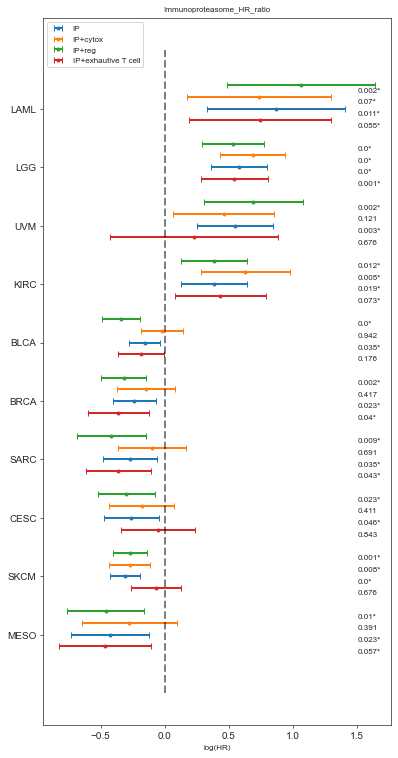

In [32]:
tt_list=['MESO','SKCM','CESC','SARC','BRCA','BLCA','KIRC','UVM','LGG','LAML']

df_tmp_immuno=df_tmp_immuno.sort_values(by=['coef'])
df_tmp_immuno=df_tmp_immuno.loc[tt_list]
df_tmp_immuno['y_value']=np.array(range(1,11))

df_tmp_immuno_cytox=df_tmp_immuno_cytox.reindex(df_tmp_immuno.index)
df_tmp_immuno_cytox=df_tmp_immuno_cytox.loc[tt_list]
df_tmp_immuno_cytox['y_value']=np.array(range(1,11))

df_tmp_immuno_reg=df_tmp_immuno_reg.reindex(df_tmp_immuno.index)
df_tmp_immuno_reg=df_tmp_immuno_reg.loc[tt_list]
df_tmp_immuno_reg['y_value']=np.array(range(1,11))

df_tmp_immuno_Exhausted_T_cell_score=df_tmp_immuno_Exhausted_T_cell_score.reindex(df_tmp_immuno.index)
df_tmp_immuno_Exhausted_T_cell_score=df_tmp_immuno_Exhausted_T_cell_score.loc[tt_list]
df_tmp_immuno_Exhausted_T_cell_score['y_value']=np.array(range(1,11))


x = np.array(df_tmp_immuno['coef'])
y = np.array(df_tmp_immuno['y_value'])
err=np.array(df_tmp_immuno['error_bar'])
y_ticks_labels = list(df_tmp_immuno.index)
l1 = np.arange(1,11,1)

x_1 = np.array(df_tmp_immuno_cytox['coef'])
y_1 = np.array(df_tmp_immuno_cytox['y_value'])
y_1=y_1+0.20
err_1=np.array(df_tmp_immuno_cytox['error_bar'])
y_ticks_labels_1 = list(df_tmp_immuno_cytox.index)
l1_1 = np.arange(1,11,1)

x_2 = np.array(df_tmp_immuno_reg['coef'])
y_2 = np.array(df_tmp_immuno_reg['y_value'])
y_2=y_2+0.40
err_2=np.array(df_tmp_immuno_reg['error_bar'])
y_ticks_labels_2 = list(df_tmp_immuno_reg.index)
l1_2 = np.arange(1,11,1)

x_3 = np.array(df_tmp_immuno_Exhausted_T_cell_score['coef'])
y_3 = np.array(df_tmp_immuno_Exhausted_T_cell_score['y_value'])
y_3=y_3-0.20
err_3=np.array(df_tmp_immuno_Exhausted_T_cell_score['error_bar'])
y_ticks_labels_3 = list(df_tmp_immuno_Exhausted_T_cell_score.index)
l1_3 = np.arange(1,11,1)

sns.set_style("ticks")
#sns.set_style (" ticks ")
fig, (ax1) = plt.subplots(1,1,figsize=(6, 11))

ax1.errorbar(x, y, xerr=err, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP') ## immuno
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y[i]-0.118),fontsize=8)
    
ax1.errorbar(x_1, y_1, xerr=err_1, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP+cytox') ## immuno adjusted for cytox
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_cytox
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y_1[i]-0.118),fontsize=8)

ax1.errorbar(x_2, y_2, xerr=err_2, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP+reg') ## immuno adjusted for regulatory
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_reg
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y_2[i]-0.118),fontsize=8)


ax1.errorbar(x_3, y_3, xerr=err_3, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP+exhautive T cell') ## Immuno adjusted for Exhaustive T cell
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_Exhausted_T_cell_score
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y_3[i]-0.118),fontsize=8)

ax1.plot([0, 0], [0, 11], color = 'black', linewidth = 2.0,alpha=0.5,linestyle="dashed")
ax1.set_yticks(l1)
ax1.set_yticklabels(y_ticks_labels, rotation='horizontal',fontsize=10)
ax1.set_title('Immunoproteasome_HR_ratio')
ax1.set_xlabel('log(HR)')
plt.xticks(fontsize=10)
fig.tight_layout(pad=3.0)
#ax1.grid(False)

#plt.savefig("/workspace/projects/immunoproteasome/plots/"+'Cox_proportional_hazard_ratio_immune_cytox_reg_exhaustive_score_all_combined_v5_v1'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()

In [33]:
hazard_ratio_df=pd.DataFrame()
hazard_ratio_df['IP[log2(HR)]']=df_tmp_immuno['coef']
hazard_ratio_df['IP[P_adjust]']=df_tmp_immuno['p_adjust']

hazard_ratio_df['IP+T_reg[log2(HR)]']= df_tmp_immuno_reg['coef']
hazard_ratio_df['IP+T_reg[P_adjust]']= df_tmp_immuno_reg['p_adjust']

hazard_ratio_df['IP+Cytoxtoxic score[log2(HR)]']=df_tmp_immuno_cytox['coef']
hazard_ratio_df['IP+Cytoxtoxic score[P_adjust]']=df_tmp_immuno_cytox['p_adjust']

hazard_ratio_df['IP+Exhausted T cell[log2(HR)]']=df_tmp_immuno_Exhausted_T_cell_score['coef']
hazard_ratio_df['IP+Exhausted T cell[P_adjust]']=df_tmp_immuno_Exhausted_T_cell_score['p_adjust']

In [34]:
hazard_ratio_df

,IP[log2(HR)],IP[P_adjust],IP+T_reg[log2(HR)],IP+T_reg[P_adjust],IP+Cytoxtoxic score[log2(HR)],IP+Cytoxtoxic score[P_adjust],IP+Exhausted T cell[log2(HR)],IP+Exhausted T cell[P_adjust]
MESO,-0.428580,0.022594,-0.460649,0.009611,-0.276175,0.390514,-0.467056,0.056940
SKCM,-0.309880,0.000006,-0.269576,0.000664,-0.273763,0.008290,-0.067762,0.675648
CESC,-0.260876,0.045738,-0.299973,0.023283,-0.180016,0.410983,-0.052589,0.842656
SARC,-0.270333,0.035320,-0.417765,0.009000,-0.100179,0.691476,-0.361130,0.043382
BRCA,-0.238237,0.022594,-0.321517,0.002077,-0.147252,0.416910,-0.360827,0.040087
BLCA,-0.156086,0.035320,-0.343369,0.000134,-0.021090,0.942189,-0.182447,0.175664
KIRC,0.385658,0.018560,0.382291,0.011520,0.628923,0.004717,0.432929,0.073341
UVM,0.544349,0.002787,0.689207,0.002181,0.459469,0.120881,0.228181,0.675648
LGG,0.577954,0.000005,0.529521,0.000229,0.685848,0.000003,0.540311,0.001347
LAML,0.865519,0.010545,1.062985,0.002077,0.736340,0.069592,0.744782,0.055450


### Supplementary figure and tables

In [41]:
import glob, os
os.chdir("/workspace/projects/immunoproteasome/data/tcga_tumor/")
tumor_tissue=[]
for  i in glob.glob("*.tsv"):
    tumor_tissue.append(i)
os.chdir("/workspace/incubator/rahul_project/")
tumor_tissue=[e for e in tumor_tissue if e not in ('THYM.tsv','TGCT.tsv','PCPG.tsv','DLBC.tsv','THCA.tsv','KICH.tsv' )]

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


ACC.tsv


<lifelines.CoxPHFitter: fitted with 74 total observations, 49 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 74
number of events observed = 25
   partial log-likelihood = -67.05
         time fit was run = 2023-02-20 06:31:01 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.01       0.99       0.35            -0.69             0.67                 0.50                 1.96
const_proteosome                      1.20       3.33       0.57             0.09             2.32                 1.09                10.14
Regulatory T cell                     4.41      82.10       1.46             1.55             7.26                 4.73              1423.89
Exhaustive T cell                     0.30       1.35       0.63            -0.94             1.54                 0.39                 4.65
Cytotoxic cells                      -2.93       0.05       1.03            -4.96            -0.91                 0.01                 0.40
age_at_initial_pathologic_diagnosis  -0.00       1.00       0.02            -0.04             0.03                 0.97                 1.03
gender                               -1.32       0.27       0.57            -2.43            -0.20                 0.09                 0.82
ajcc_pathologic_tumor_stage           0.88       2.41       0.34             0.22             1.54                 1.24                 4.68
TMB                                   0.18       1.20       0.11            -0.03             0.40                 0.97                 1.49
purity                               11.85   1.40e+05       4.49             3.06            20.64                21.24             9.19e+08

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -0.02   0.98       0.03
const_proteosome                     2.12   0.03       4.87
Regulatory T cell                    3.03 <0.005       8.67
Exhaustive T cell                    0.47   0.64       0.65
Cytotoxic cells                     -2.84 <0.005       7.79
age_at_initial_pathologic_diagnosis -0.11   0.91       0.13
gender                              -2.31   0.02       5.59
ajcc_pathologic_tumor_stage          2.61   0.01       6.77
TMB                                  1.65   0.10       3.33
purity                               2.64   0.01       6.92
---
Concordance = 0.89
Partial AIC = 154.10
log-likelihood ratio test = 54.79 on 10 df
-log2(p) of ll-ratio test = 24.79

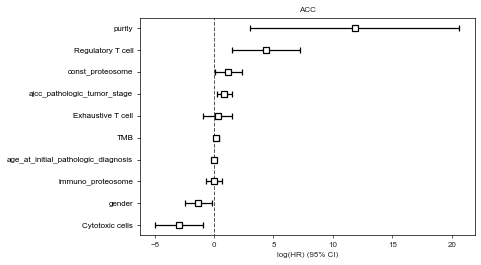

LIHC.tsv


<lifelines.CoxPHFitter: fitted with 327 total observations, 219 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 327
number of events observed = 108
   partial log-likelihood = -519.27
         time fit was run = 2023-02-20 06:31:03 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                     0.08       1.09       0.13            -0.17             0.33                 0.85                 1.40
const_proteosome                      0.30       1.35       0.20            -0.10             0.70                 0.91                 2.01
Regulatory T cell                     0.64       1.90       0.43            -0.20             1.48                 0.82                 4.40
Exhaustive T cell                     0.33       1.39       0.26            -0.18             0.83                 0.84                 2.29
Cytotoxic cells                      -1.39       0.25       0.34            -2.05            -0.73                 0.13                 0.48
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.03
gender                                0.29       1.34       0.21            -0.12             0.71                 0.88                 2.03
ajcc_pathologic_tumor_stage           0.44       1.55       0.11             0.22             0.66                 1.25                 1.93
TMB                                   0.07       1.07       0.04            -0.01             0.14                 0.99                 1.15
purity                                0.61       1.85       0.63            -0.63             1.86                 0.53                 6.41

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                    0.66   0.51       0.97
const_proteosome                     1.48   0.14       2.86
Regulatory T cell                    1.50   0.13       2.91
Exhaustive T cell                    1.27   0.20       2.30
Cytotoxic cells                     -4.10 <0.005      14.59
age_at_initial_pathologic_diagnosis  1.16   0.24       2.03
gender                               1.37   0.17       2.56
ajcc_pathologic_tumor_stage          3.96 <0.005      13.72
TMB                                  1.78   0.07       3.75
purity                               0.97   0.33       1.59
---
Concordance = 0.50
Partial AIC = 1058.54
log-likelihood ratio test = 50.27 on 10 df
-log2(p) of ll-ratio test = 22.01

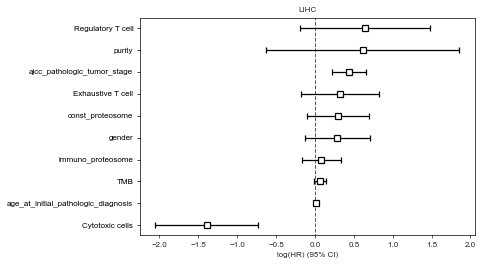

MESO.tsv


<lifelines.CoxPHFitter: fitted with 80 total observations, 12 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 80
number of events observed = 68
   partial log-likelihood = -229.77
         time fit was run = 2023-02-20 06:31:03 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.80       0.45       0.27            -1.33            -0.27                 0.26                 0.76
const_proteosome                      1.05       2.86       0.39             0.28             1.82                 1.32                 6.17
Regulatory T cell                     0.35       1.42       0.43            -0.48             1.19                 0.62                 3.27
Exhaustive T cell                     0.37       1.45       0.32            -0.26             1.00                 0.77                 2.71
Cytotoxic cells                      -0.59       0.55       0.49            -1.56             0.38                 0.21                 1.46
age_at_initial_pathologic_diagnosis   0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
gender                                0.50       1.65       0.34            -0.17             1.18                 0.84                 3.25
ajcc_pathologic_tumor_stage          -0.14       0.87       0.15            -0.44             0.15                 0.64                 1.17
TMB                                   0.08       1.08       0.18            -0.28             0.43                 0.75                 1.54
purity                               -2.06       0.13       0.77            -3.57            -0.55                 0.03                 0.57

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -2.98 <0.005       8.44
const_proteosome                     2.67   0.01       7.04
Regulatory T cell                    0.83   0.41       1.30
Exhaustive T cell                    1.16   0.25       2.01
Cytotoxic cells                     -1.20   0.23       2.12
age_at_initial_pathologic_diagnosis  0.12   0.90       0.15
gender                               1.46   0.14       2.80
ajcc_pathologic_tumor_stage         -0.95   0.34       1.55
TMB                                  0.42   0.68       0.56
purity                              -2.68   0.01       7.09
---
Concordance = 0.65
Partial AIC = 479.54
log-likelihood ratio test = 23.78 on 10 df
-log2(p) of ll-ratio test = 6.93

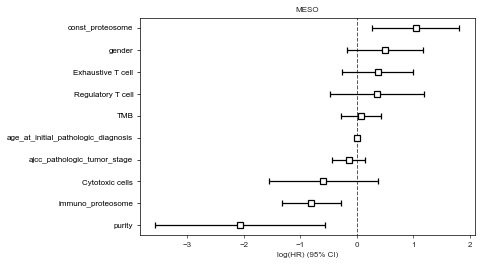

STAD.tsv


<lifelines.CoxPHFitter: fitted with 359 total observations, 224 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 359
number of events observed = 135
   partial log-likelihood = -676.85
         time fit was run = 2023-02-20 06:31:05 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.06       0.95       0.14            -0.33             0.22                 0.72                 1.24
const_proteosome                      0.10       1.11       0.21            -0.30             0.51                 0.74                 1.67
Regulatory T cell                     0.35       1.42       0.32            -0.28             0.98                 0.75                 2.66
Exhaustive T cell                    -0.34       0.71       0.29            -0.90             0.22                 0.41                 1.24
Cytotoxic cells                       0.33       1.39       0.41            -0.48             1.13                 0.62                 3.10
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
gender                                0.01       1.01       0.20            -0.38             0.39                 0.69                 1.47
ajcc_pathologic_tumor_stage           0.63       1.88       0.12             0.40             0.86                 1.49                 2.37
TMB                                  -0.03       0.97       0.01            -0.05            -0.00                 0.95                 1.00
purity                               -0.26       0.77       0.54            -1.32             0.79                 0.27                 2.21

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -0.40   0.69       0.54
const_proteosome                     0.50   0.62       0.70
Regulatory T cell                    1.08   0.28       1.83
Exhaustive T cell                   -1.20   0.23       2.11
Cytotoxic cells                      0.80   0.42       1.24
age_at_initial_pathologic_diagnosis  3.40 <0.005      10.55
gender                               0.03   0.98       0.03
ajcc_pathologic_tumor_stage          5.34 <0.005      23.38
TMB                                 -2.23   0.03       5.27
purity                              -0.48   0.63       0.67
---
Concordance = 0.68
Partial AIC = 1373.70
log-likelihood ratio test = 53.93 on 10 df
-log2(p) of ll-ratio test = 24.26

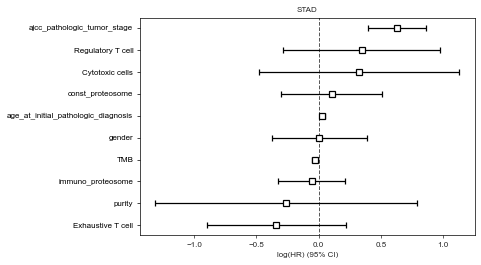

ESCA.tsv


<lifelines.CoxPHFitter: fitted with 141 total observations, 85 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 56
   partial log-likelihood = -210.45
         time fit was run = 2023-02-20 06:31:06 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                     0.00       1.00       0.20            -0.39             0.39                 0.68                 1.48
const_proteosome                      0.05       1.05       0.31            -0.56             0.66                 0.57                 1.93
Regulatory T cell                     0.47       1.60       0.48            -0.46             1.41                 0.63                 4.08
Exhaustive T cell                    -0.02       0.98       0.53            -1.07             1.03                 0.34                 2.80
Cytotoxic cells                       0.88       2.41       0.71            -0.51             2.26                 0.60                 9.60
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.01             0.04                 0.99                 1.04
gender                               -0.47       0.63       0.50            -1.44             0.50                 0.24                 1.65
ajcc_pathologic_tumor_stage           0.86       2.36       0.20             0.46             1.25                 1.59                 3.49
TMB                                  -0.00       1.00       0.03            -0.07             0.06                 0.93                 1.06
purity                                2.53      12.50       1.11             0.36             4.69                 1.43               109.07

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                    0.01   0.99       0.01
const_proteosome                     0.16   0.87       0.20
Regulatory T cell                    0.99   0.32       1.64
Exhaustive T cell                   -0.03   0.97       0.04
Cytotoxic cells                      1.24   0.21       2.23
age_at_initial_pathologic_diagnosis  1.10   0.27       1.89
gender                              -0.94   0.35       1.53
ajcc_pathologic_tumor_stage          4.27 <0.005      15.67
TMB                                 -0.11   0.91       0.13
purity                               2.28   0.02       5.49
---
Concordance = 0.68
Partial AIC = 440.90
log-likelihood ratio test = 28.62 on 10 df
-log2(p) of ll-ratio test = 9.44

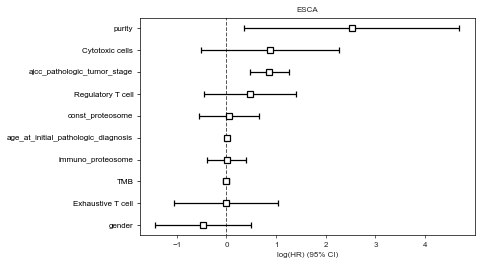

HNSC.tsv


<lifelines.CoxPHFitter: fitted with 421 total observations, 243 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 421
number of events observed = 178
   partial log-likelihood = -924.77
         time fit was run = 2023-02-20 06:31:08 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                     0.22       1.24       0.13            -0.03             0.46                 0.97                 1.59
const_proteosome                      0.00       1.00       0.18            -0.35             0.36                 0.70                 1.43
Regulatory T cell                     0.45       1.57       0.33            -0.20             1.09                 0.82                 2.99
Exhaustive T cell                    -0.45       0.64       0.29            -1.03             0.13                 0.36                 1.13
Cytotoxic cells                      -0.52       0.59       0.35            -1.22             0.17                 0.30                 1.18
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
gender                                0.23       1.26       0.17            -0.11             0.57                 0.90                 1.77
ajcc_pathologic_tumor_stage           0.38       1.47       0.10             0.19             0.57                 1.21                 1.78
TMB                                   0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
purity                                0.67       1.96       0.52            -0.35             1.69                 0.70                 5.43

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                    1.73   0.08       3.59
const_proteosome                     0.02   0.99       0.02
Regulatory T cell                    1.37   0.17       2.54
Exhaustive T cell                   -1.53   0.13       2.99
Cytotoxic cells                     -1.48   0.14       2.86
age_at_initial_pathologic_diagnosis  3.46 <0.005      10.87
gender                               1.35   0.18       2.49
ajcc_pathologic_tumor_stage          3.96 <0.005      13.70
TMB                                  0.07   0.94       0.08
purity                               1.29   0.20       2.33
---
Concordance = 0.50
Partial AIC = 1869.55
log-likelihood ratio test = 42.56 on 10 df
-log2(p) of ll-ratio test = 17.36

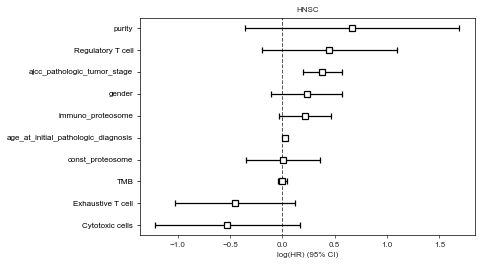

COAD.tsv


<lifelines.CoxPHFitter: fitted with 259 total observations, 199 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 259
number of events observed = 60
   partial log-likelihood = -262.73
         time fit was run = 2023-02-20 06:31:09 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.35       0.70       0.26            -0.86             0.16                 0.42                 1.17
const_proteosome                      0.35       1.42       0.46            -0.55             1.26                 0.58                 3.52
Regulatory T cell                     0.26       1.30       0.54            -0.80             1.33                 0.45                 3.76
Exhaustive T cell                     0.16       1.17       0.50            -0.82             1.14                 0.44                 3.13
Cytotoxic cells                       0.44       1.55       0.73            -0.98             1.86                 0.37                 6.43
age_at_initial_pathologic_diagnosis   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
gender                               -0.27       0.76       0.28            -0.83             0.28                 0.44                 1.33
ajcc_pathologic_tumor_stage           0.98       2.66       0.19             0.61             1.34                 1.85                 3.83
TMB                                   0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
purity                               -0.01       0.99       0.84            -1.65             1.64                 0.19                 5.13

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -1.35   0.18       2.50
const_proteosome                     0.77   0.44       1.18
Regulatory T cell                    0.48   0.63       0.67
Exhaustive T cell                    0.32   0.75       0.42
Cytotoxic cells                      0.60   0.55       0.88
age_at_initial_pathologic_diagnosis  3.03 <0.005       8.68
gender                              -0.96   0.34       1.56
ajcc_pathologic_tumor_stage          5.25 <0.005      22.63
TMB                                  0.41   0.68       0.56
purity                              -0.01   0.99       0.01
---
Concordance = 0.50
Partial AIC = 545.45
log-likelihood ratio test = 39.15 on 10 df
-log2(p) of ll-ratio test = 15.35

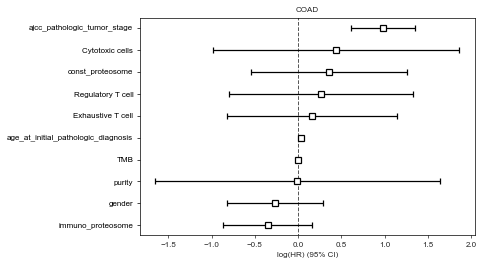

PAAD.tsv


<lifelines.CoxPHFitter: fitted with 141 total observations, 59 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 82
   partial log-likelihood = -330.39
         time fit was run = 2023-02-20 06:31:10 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                     0.28       1.32       0.29            -0.29             0.85                 0.75                 2.34
const_proteosome                      0.09       1.10       0.36            -0.61             0.80                 0.54                 2.22
Regulatory T cell                     0.17       1.18       0.44            -0.71             1.04                 0.49                 2.82
Exhaustive T cell                    -0.22       0.80       0.36            -0.92             0.47                 0.40                 1.61
Cytotoxic cells                       0.30       1.35       0.46            -0.60             1.20                 0.55                 3.31
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
gender                                0.20       1.23       0.25            -0.29             0.70                 0.75                 2.00
ajcc_pathologic_tumor_stage          -0.12       0.89       0.25            -0.61             0.37                 0.55                 1.45
TMB                                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
purity                               -1.00       0.37       0.54            -2.06             0.06                 0.13                 1.06

                                        z    p   -log2(p)
covariate                                                
immuno_proteosome                    0.97 0.33       1.58
const_proteosome                     0.26 0.80       0.33
Regulatory T cell                    0.37 0.71       0.49
Exhaustive T cell                   -0.62 0.53       0.91
Cytotoxic cells                      0.65 0.51       0.96
age_at_initial_pathologic_diagnosis  1.06 0.29       1.79
gender                               0.81 0.42       1.26
ajcc_pathologic_tumor_stage         -0.47 0.63       0.66
TMB                                  0.08 0.94       0.09
purity                              -1.85 0.06       3.97
---
Concordance = 0.50
Partial AIC = 680.78
log-likelihood ratio test = 10.27 on 10 df
-log2(p) of ll-ratio test = 1.26

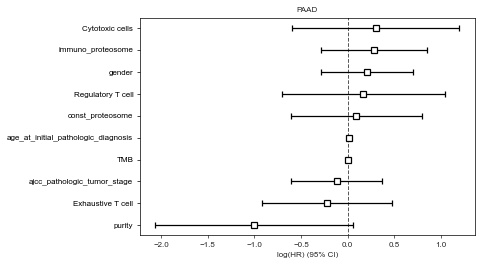

UVM.tsv


<lifelines.CoxPHFitter: fitted with 79 total observations, 57 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 79
number of events observed = 22
   partial log-likelihood = -62.71
         time fit was run = 2023-02-20 06:31:11 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.00       1.00       0.37            -0.73             0.72                 0.48                 2.05
const_proteosome                      0.92       2.51       1.13            -1.29             3.13                 0.27                22.87
Regulatory T cell                    -1.24       0.29       1.02            -3.25             0.77                 0.04                 2.16
Exhaustive T cell                     2.30      10.00       0.88             0.58             4.02                 1.79                55.80
Cytotoxic cells                       0.53       1.70       0.97            -1.37             2.43                 0.26                11.31
age_at_initial_pathologic_diagnosis   0.06       1.06       0.02             0.01             0.11                 1.01                 1.11
gender                               -0.04       0.96       0.51            -1.04             0.96                 0.35                 2.60
ajcc_pathologic_tumor_stage           1.56       4.75       0.54             0.51             2.61                 1.66                13.63
TMB                                  -0.24       0.79       0.92            -2.03             1.56                 0.13                 4.74
purity                                4.36      78.17       2.61            -0.76             9.47                 0.47             13018.47

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -0.01   0.99       0.01
const_proteosome                     0.81   0.42       1.27
Regulatory T cell                   -1.21   0.23       2.14
Exhaustive T cell                    2.63   0.01       6.85
Cytotoxic cells                      0.55   0.58       0.78
age_at_initial_pathologic_diagnosis  2.41   0.02       5.97
gender                              -0.08   0.93       0.10
ajcc_pathologic_tumor_stage          2.90 <0.005       8.08
TMB                                 -0.26   0.79       0.33
purity                               1.67   0.09       3.40
---
Concordance = 0.84
Partial AIC = 145.43
log-likelihood ratio test = 33.92 on 10 df
-log2(p) of ll-ratio test = 12.36

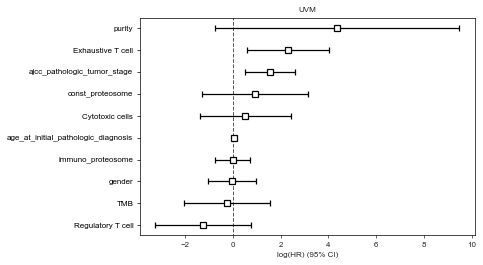

SARC.tsv
LUSC.tsv


<lifelines.CoxPHFitter: fitted with 447 total observations, 253 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 447
number of events observed = 194
   partial log-likelihood = -995.82
         time fit was run = 2023-02-20 06:31:14 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                     0.14       1.15       0.12            -0.10             0.37                 0.91                 1.45
const_proteosome                     -0.07       0.94       0.18            -0.42             0.29                 0.65                 1.34
Regulatory T cell                     0.73       2.08       0.29             0.16             1.30                 1.18                 3.67
Exhaustive T cell                    -0.21       0.81       0.28            -0.76             0.35                 0.47                 1.42
Cytotoxic cells                      -0.09       0.92       0.38            -0.84             0.67                 0.43                 1.95
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.00             0.03                 1.00                 1.04
gender                               -0.22       0.80       0.17            -0.55             0.12                 0.57                 1.13
ajcc_pathologic_tumor_stage           0.26       1.29       0.09             0.09             0.43                 1.09                 1.53
TMB                                  -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
purity                                0.45       1.57       0.49            -0.51             1.41                 0.60                 4.09

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                    1.13   0.26       1.96
const_proteosome                    -0.37   0.71       0.48
Regulatory T cell                    2.51   0.01       6.39
Exhaustive T cell                   -0.73   0.47       1.10
Cytotoxic cells                     -0.22   0.82       0.28
age_at_initial_pathologic_diagnosis  1.91   0.06       4.15
gender                              -1.27   0.20       2.29
ajcc_pathologic_tumor_stage          2.96 <0.005       8.33
TMB                                 -0.39   0.69       0.53
purity                               0.92   0.36       1.49
---
Concordance = 0.62
Partial AIC = 2011.65
log-likelihood ratio test = 24.76 on 10 df
-log2(p) of ll-ratio test = 7.42

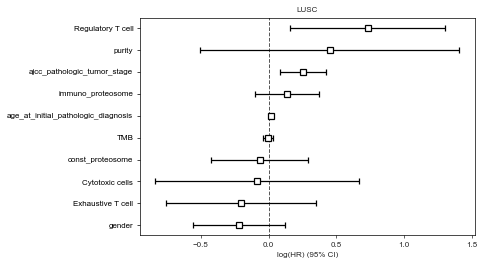

BLCA.tsv


<lifelines.CoxPHFitter: fitted with 390 total observations, 218 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 390
number of events observed = 172
   partial log-likelihood = -868.58
         time fit was run = 2023-02-20 06:31:15 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.25       0.78       0.11            -0.47            -0.03                 0.63                 0.97
const_proteosome                      0.36       1.43       0.20            -0.02             0.75                 0.98                 2.11
Regulatory T cell                     0.90       2.46       0.33             0.25             1.55                 1.28                 4.72
Exhaustive T cell                    -0.08       0.93       0.31            -0.68             0.53                 0.50                 1.71
Cytotoxic cells                      -0.03       0.97       0.37            -0.75             0.69                 0.47                 1.99
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
gender                                0.09       1.10       0.17            -0.25             0.43                 0.78                 1.54
ajcc_pathologic_tumor_stage           0.40       1.50       0.10             0.20             0.60                 1.23                 1.83
TMB                                  -0.09       0.91       0.03            -0.15            -0.04                 0.86                 0.96
purity                                0.17       1.19       0.47            -0.75             1.10                 0.47                 3.01

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -2.20   0.03       5.15
const_proteosome                     1.84   0.07       3.93
Regulatory T cell                    2.71   0.01       7.24
Exhaustive T cell                   -0.24   0.81       0.31
Cytotoxic cells                     -0.09   0.93       0.10
age_at_initial_pathologic_diagnosis  2.63   0.01       6.88
gender                               0.54   0.59       0.76
ajcc_pathologic_tumor_stage          3.95 <0.005      13.65
TMB                                 -3.52 <0.005      11.19
purity                               0.37   0.71       0.49
---
Concordance = 0.71
Partial AIC = 1757.16
log-likelihood ratio test = 85.18 on 10 df
-log2(p) of ll-ratio test = 44.24

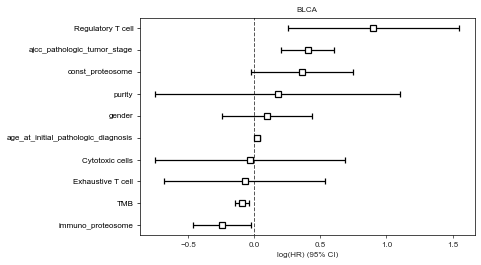

LGG.tsv
CHOL.tsv


<lifelines.CoxPHFitter: fitted with 36 total observations, 18 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 36
number of events observed = 18
   partial log-likelihood = -46.82
         time fit was run = 2023-02-20 06:31:17 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.08       0.92       0.40            -0.87             0.70                 0.42                 2.02
const_proteosome                      1.19       3.29       0.75            -0.29             2.67                 0.75                14.40
Regulatory T cell                    -0.65       0.52       1.09            -2.79             1.48                 0.06                 4.41
Exhaustive T cell                     0.83       2.30       0.95            -1.03             2.70                 0.36                14.89
Cytotoxic cells                      -2.16       0.12       1.00            -4.13            -0.19                 0.02                 0.83
age_at_initial_pathologic_diagnosis  -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
gender                                0.34       1.41       0.70            -1.04             1.72                 0.35                 5.60
ajcc_pathologic_tumor_stage           0.29       1.34       0.23            -0.15             0.74                 0.86                 2.09
TMB                                   0.31       1.36       0.14             0.03             0.58                 1.04                 1.79
purity                               -2.92       0.05       2.27            -7.38             1.54                 0.00                 4.66

                                        z    p   -log2(p)
covariate                                                
immuno_proteosome                   -0.21 0.84       0.26
const_proteosome                     1.58 0.11       3.13
Regulatory T cell                   -0.60 0.55       0.86
Exhaustive T cell                    0.88 0.38       1.39
Cytotoxic cells                     -2.15 0.03       4.99
age_at_initial_pathologic_diagnosis -0.39 0.70       0.52
gender                               0.49 0.63       0.68
ajcc_pathologic_tumor_stage          1.29 0.20       2.33
TMB                                  2.21 0.03       5.19
purity                              -1.28 0.20       2.33
---
Concordance = 0.72
Partial AIC = 113.64
log-likelihood ratio test = 11.42 on 10 df
-log2(p) of ll-ratio test = 1.62

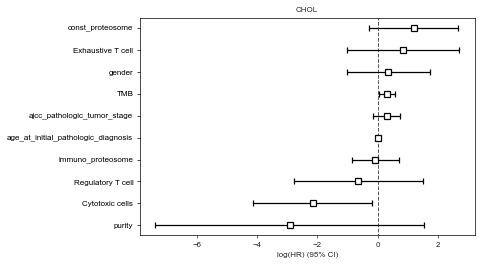

LAML.tsv
GBM.tsv
SKCM.tsv


<lifelines.CoxPHFitter: fitted with 377 total observations, 209 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 377
number of events observed = 168
   partial log-likelihood = -799.86
         time fit was run = 2023-02-20 06:31:20 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.02       0.98       0.11            -0.24             0.20                 0.78                 1.22
const_proteosome                      0.59       1.81       0.18             0.24             0.94                 1.28                 2.56
Regulatory T cell                     0.48       1.62       0.36            -0.23             1.19                 0.80                 3.30
Exhaustive T cell                    -1.29       0.27       0.32            -1.93            -0.66                 0.15                 0.52
Cytotoxic cells                       0.63       1.88       0.36            -0.08             1.34                 0.92                 3.82
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.01             0.03                 1.01                 1.03
gender                               -0.19       0.82       0.18            -0.54             0.15                 0.58                 1.17
ajcc_pathologic_tumor_stage           0.46       1.58       0.10             0.26             0.66                 1.29                 1.93
TMB                                  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
purity                                0.55       1.73       0.46            -0.35             1.44                 0.71                 4.24

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -0.19   0.85       0.24
const_proteosome                     3.34 <0.005      10.20
Regulatory T cell                    1.33   0.18       2.45
Exhaustive T cell                   -4.02 <0.005      14.07
Cytotoxic cells                      1.74   0.08       3.62
age_at_initial_pathologic_diagnosis  3.54 <0.005      11.26
gender                              -1.09   0.27       1.87
ajcc_pathologic_tumor_stage          4.48 <0.005      17.02
TMB                                 -0.45   0.65       0.62
purity                               1.20   0.23       2.12
---
Concordance = 0.50
Partial AIC = 1619.73
log-likelihood ratio test = 81.85 on 10 df
-log2(p) of ll-ratio test = 42.06

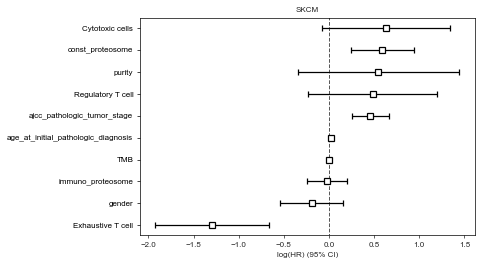

KIRP.tsv


<lifelines.CoxPHFitter: fitted with 244 total observations, 210 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 34
   partial log-likelihood = -136.36
         time fit was run = 2023-02-20 06:31:22 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.64       0.53       0.41            -1.45             0.17                 0.23                 1.19
const_proteosome                     -0.66       0.52       0.63            -1.90             0.58                 0.15                 1.78
Regulatory T cell                     0.32       1.37       0.77            -1.20             1.83                 0.30                 6.24
Exhaustive T cell                     1.17       3.22       0.50             0.20             2.14                 1.22                 8.52
Cytotoxic cells                       0.51       1.66       0.77            -1.00             2.01                 0.37                 7.48
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
gender                                0.17       1.19       0.42            -0.66             1.00                 0.52                 2.72
ajcc_pathologic_tumor_stage           1.12       3.08       0.19             0.76             1.49                 2.14                 4.43
TMB                                  -0.17       0.84       0.14            -0.45             0.11                 0.64                 1.12
purity                                1.42       4.15       1.49            -1.49             4.34                 0.23                76.46

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -1.54   0.12       3.02
const_proteosome                    -1.05   0.29       1.76
Regulatory T cell                    0.41   0.68       0.55
Exhaustive T cell                    2.36   0.02       5.78
Cytotoxic cells                      0.66   0.51       0.97
age_at_initial_pathologic_diagnosis  1.02   0.31       1.69
gender                               0.40   0.69       0.54
ajcc_pathologic_tumor_stage          6.04 <0.005      29.30
TMB                                 -1.18   0.24       2.08
purity                               0.96   0.34       1.56
---
Concordance = 0.50
Partial AIC = 292.73
log-likelihood ratio test = 51.42 on 10 df
-log2(p) of ll-ratio test = 22.71

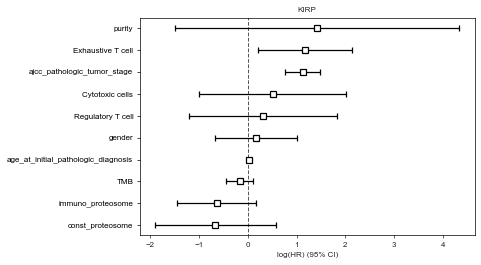

BRCA.tsv


<lifelines.CoxPHFitter: fitted with 961 total observations, 836 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 961
number of events observed = 125
   partial log-likelihood = -658.58
         time fit was run = 2023-02-20 06:31:26 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -0.26       0.77       0.15            -0.54             0.03                 0.58                 1.03
const_proteosome                      0.17       1.18       0.23            -0.29             0.62                 0.75                 1.86
Regulatory T cell                     1.20       3.32       0.37             0.47             1.92                 1.61                 6.85
Exhaustive T cell                    -0.14       0.87       0.30            -0.73             0.45                 0.48                 1.57
Cytotoxic cells                      -0.08       0.92       0.40            -0.86             0.70                 0.42                 2.01
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
gender                                0.13       1.13       1.01            -1.85             2.10                 0.16                 8.17
ajcc_pathologic_tumor_stage           0.74       2.10       0.12             0.51             0.97                 1.67                 2.64
TMB                                   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
purity                               -0.14       0.87       0.64            -1.39             1.11                 0.25                 3.02

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                   -1.78   0.08       3.72
const_proteosome                     0.71   0.48       1.07
Regulatory T cell                    3.24 <0.005       9.70
Exhaustive T cell                   -0.46   0.65       0.63
Cytotoxic cells                     -0.20   0.84       0.25
age_at_initial_pathologic_diagnosis  4.59 <0.005      17.78
gender                               0.13   0.90       0.15
ajcc_pathologic_tumor_stage          6.32 <0.005      31.79
TMB                                  2.74   0.01       7.34
purity                              -0.22   0.82       0.28
---
Concordance = 0.50
Partial AIC = 1337.17
log-likelihood ratio test = 77.28 on 10 df
-log2(p) of ll-ratio test = 39.09

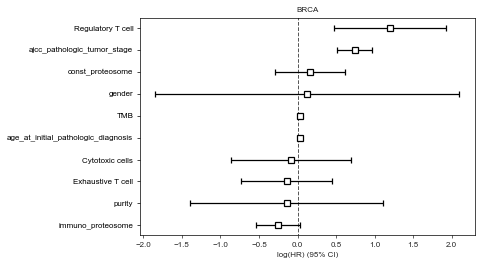

KIRC.tsv


<lifelines.CoxPHFitter: fitted with 342 total observations, 251 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 342
number of events observed = 91
   partial log-likelihood = -423.33
         time fit was run = 2023-02-20 06:31:28 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                     0.11       1.12       0.24            -0.36             0.59                 0.69                 1.81
const_proteosome                      0.50       1.64       0.32            -0.13             1.13                 0.87                 3.08
Regulatory T cell                    -0.35       0.70       0.46            -1.25             0.54                 0.29                 1.72
Exhaustive T cell                    -0.19       0.83       0.30            -0.77             0.39                 0.47                 1.48
Cytotoxic cells                      -0.50       0.60       0.42            -1.32             0.31                 0.27                 1.37
age_at_initial_pathologic_diagnosis   0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
gender                                0.02       1.02       0.23            -0.44             0.48                 0.65                 1.61
ajcc_pathologic_tumor_stage           0.70       2.01       0.11             0.49             0.91                 1.64                 2.48
TMB                                   0.22       1.25       0.08             0.08             0.37                 1.08                 1.45
purity                               -1.10       0.33       0.88            -2.82             0.62                 0.06                 1.85

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                    0.47   0.64       0.65
const_proteosome                     1.54   0.12       3.03
Regulatory T cell                   -0.77   0.44       1.19
Exhaustive T cell                   -0.63   0.53       0.93
Cytotoxic cells                     -1.21   0.23       2.13
age_at_initial_pathologic_diagnosis  4.46 <0.005      16.90
gender                               0.09   0.93       0.11
ajcc_pathologic_tumor_stage          6.65 <0.005      35.03
TMB                                  2.97 <0.005       8.41
purity                              -1.26   0.21       2.26
---
Concordance = 0.50
Partial AIC = 866.66
log-likelihood ratio test = 91.50 on 10 df
-log2(p) of ll-ratio test = 48.40

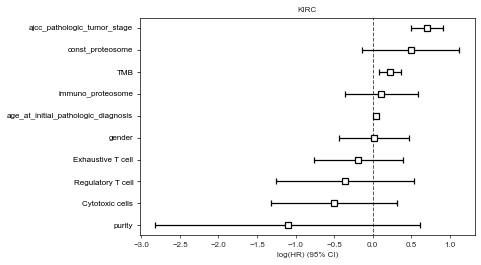

LUAD.tsv


<lifelines.CoxPHFitter: fitted with 474 total observations, 309 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 474
number of events observed = 165
   partial log-likelihood = -843.86
         time fit was run = 2023-02-20 06:31:30 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                     0.15       1.16       0.12            -0.10             0.39                 0.91                 1.48
const_proteosome                      0.52       1.69       0.19             0.15             0.89                 1.17                 2.44
Regulatory T cell                     0.02       1.02       0.34            -0.64             0.68                 0.53                 1.97
Exhaustive T cell                    -0.06       0.94       0.27            -0.59             0.47                 0.55                 1.61
Cytotoxic cells                      -0.54       0.58       0.33            -1.19             0.11                 0.31                 1.11
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
gender                                0.14       1.15       0.17            -0.18             0.47                 0.83                 1.59
ajcc_pathologic_tumor_stage           0.53       1.69       0.08             0.38             0.68                 1.46                 1.97
TMB                                   0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
purity                                0.68       1.98       0.55            -0.40             1.77                 0.67                 5.88

                                        z      p   -log2(p)
covariate                                                  
immuno_proteosome                    1.18   0.24       2.08
const_proteosome                     2.78   0.01       7.51
Regulatory T cell                    0.05   0.96       0.06
Exhaustive T cell                   -0.22   0.83       0.27
Cytotoxic cells                     -1.63   0.10       3.28
age_at_initial_pathologic_diagnosis  1.98   0.05       4.39
gender                               0.85   0.40       1.33
ajcc_pathologic_tumor_stage          6.92 <0.005      37.67
TMB                                  0.17   0.87       0.20
purity                               1.23   0.22       2.20
---
Concordance = 0.50
Partial AIC = 1707.72
log-likelihood ratio test = 64.22 on 10 df
-log2(p) of ll-ratio test = 30.71

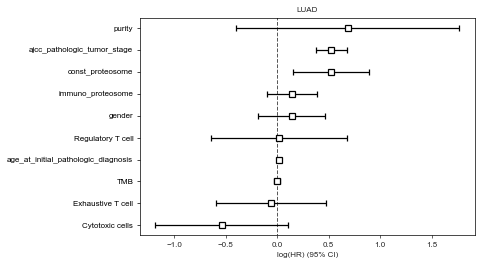

READ.tsv


<lifelines.CoxPHFitter: fitted with 80 total observations, 66 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 80
number of events observed = 14
   partial log-likelihood = -35.65
         time fit was run = 2023-02-20 06:31:31 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
immuno_proteosome                    -1.18       0.31       0.76            -2.66             0.31                 0.07                 1.37
const_proteosome                      2.44      11.51       1.13             0.22             4.67                 1.25               106.29
Regulatory T cell                     3.45      31.49       1.66             0.20             6.70                 1.22               810.27
Exhaustive T cell                     1.01       2.74       1.33            -1.59             3.61                 0.20                37.09
Cytotoxic cells                      -0.18       0.83       1.85            -3.80             3.44                 0.02                31.05
age_at_initial_pathologic_diagnosis   0.10       1.11       0.04             0.02             0.18                 1.02                 1.20
gender                               -0.10       0.91       0.85            -1.77             1.58                 0.17                 4.84
ajcc_pathologic_tumor_stage           0.39       1.48       0.41            -0.41             1.19                 0.66                 3.30
TMB                                  -0.07       0.94       0.17            -0.40             0.27                 0.67                 1.31
purity                                5.53     251.66       3.15            -0.65            11.70                 0.52             1.21e+05

                                        z    p   -log2(p)
covariate                                                
immuno_proteosome                   -1.55 0.12       3.04
const_proteosome                     2.15 0.03       5.00
Regulatory T cell                    2.08 0.04       4.74
Exhaustive T cell                    0.76 0.45       1.16
Cytotoxic cells                     -0.10 0.92       0.12
age_at_initial_pathologic_diagnosis  2.56 0.01       6.56
gender                              -0.11 0.91       0.14
ajcc_pathologic_tumor_stage          0.95 0.34       1.56
TMB                                 -0.38 0.70       0.51
purity                               1.75 0.08       3.66
---
Concordance = 0.85
Partial AIC = 91.29
log-likelihood ratio test = 25.13 on 10 df
-log2(p) of ll-ratio test = 7.62

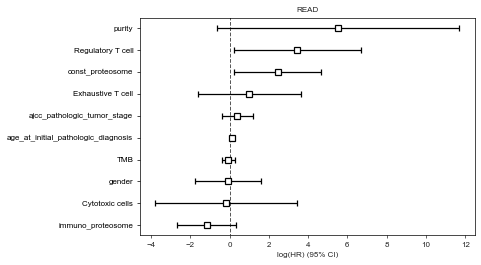

In [15]:
######## tumor purity information####################################################################
tumor_purity_df=pd.read_csv("/workspace/projects/immunoproteasome/data/purity_data/TCGA_mastercalls.abs_tables_JSedit.fixed.txt",sep='\t')
tumor_purity_df['sample_id']=tumor_purity_df['array'].str.split('-').str[0:3].str.join('.')
tumor_purity_df=tumor_purity_df[['purity','sample_id']]
tumor_purity_df=tumor_purity_df.set_index('sample_id')
#### Mutational file ##############################################################################
tumor_mutation_df = pd.read_csv('/workspace/projects/immunoproteasome/data/tcga_cohort.txt', sep="\t",header = 0)
tumor_mutation_df['TMB']=tumor_mutation_df['total']/50
tumor_mutation_df['Tumor_Sample_Barcode']=tumor_mutation_df['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('.')
tumor_mutation_df=tumor_mutation_df.set_index('Tumor_Sample_Barcode')
######### stage age gender included into the list of variables####################################
xls_1 = pd.ExcelFile('/workspace/shared/dataset/tcga_exome/tcga_cdr/mmc1.xlsx')
df_1 = xls_1.parse(0)
df_age_sex_grade_info=df_1[['bcr_patient_barcode','type','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','OS','OS.time']]
df_age_sex_grade_info['bcr_patient_barcode']=df_age_sex_grade_info['bcr_patient_barcode'].str.split('-').str[0:3].str.join('.')
df_age_sex_grade_info=df_age_sex_grade_info.set_index('bcr_patient_barcode')
df_age_sex_grade_info['gender']=df_age_sex_grade_info['gender'].replace(['MALE','FEMALE'],[1,2])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage IA','Stage IB','Stage IIA','Stage IIB','Stage IIC','Stage IIIA','Stage IIIB','Stage IIIC','Stage IVA','Stage IVB','Stage IVC'],['Stage I','Stage I','Stage II','Stage II','Stage II','Stage III','Stage III','Stage III','Stage IV','Stage IV','Stage IV'])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage I','Stage II','Stage III','Stage IV'],[1,2,3,4])
##################################################################################################
xls = pd.ExcelFile('/workspace/shared/dataset/tcga_exome/tcga_cdr/mmc1.xlsx')
df = xls.parse(0)
###================================================================================================

input_path1="/workspace/projects/immunoproteasome/data/tcga_tumor/"
#input_path2="/workspace/projects/immunoproteasome/R_code/v1.1/03_output/"
#input_path2="/workspace/projects/immunoproteasome/03_output_v1/"
input_path3="/workspace/projects/immunoproteasome/v1_copy_4/03_output/"
cytotoxic_hazard_summary=[]
tumor_tissue1=[]

tumor_tissue.remove('UCS.tsv')
tumor_tissue.remove('OV.tsv')
tumor_tissue.remove('CESC.tsv')
tumor_tissue.remove('PRAD.tsv')
tumor_tissue.remove('UCEC.tsv')

for i in range(len(tumor_tissue)):
    #print(tumor_tissue[i])
    gene_data_frame=pd.read_csv(input_path1+tumor_tissue[i],sep='\t',index_col=0)
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame=gene_data_frame.T+1
    
    log_gene_data_frame=np.log2(gene_data_frame)
    log_gene_data_frame['const_proteosome']=(1/3)*(log_gene_data_frame['PSMB5']+log_gene_data_frame['PSMB6']+log_gene_data_frame['PSMB7'])
    log_gene_data_frame['immuno_proteosome']=(1/3)*(log_gene_data_frame['PSMB8']+log_gene_data_frame['PSMB9']+log_gene_data_frame['PSMB10'])
    #log_gene_data_frame['Exhausted_T_cell_score']=(1/3)*(log_gene_data_frame['LAG3']+log_gene_data_frame['HAVCR2']+log_gene_data_frame['PDCD1'])
    
    #df1=df[['bcr_patient_barcode','type','OS','OS.time','DSS','DSS.time','DFI','DFI.time','PFI','PFI.time']]
    #df1['bcr_patient_barcode']=df1['bcr_patient_barcode'].str.split('-').str[0:3].str.join('.')
    #df1=df1.set_index('bcr_patient_barcode')

    #df2=df1[['OS','OS.time']]
    #df3=pd.merge(log_gene_data_frame[['const_proteosome','immuno_proteosome','Exhausted_T_cell_score']],df2,left_index=True, right_index=True)
    #df3=df3.dropna()
    
    immune_gsva_score=pd.read_csv(input_path3+'GSVA_'+'immune_cells_'+tumor_tissue[i],sep='\t')
    
    df3=pd.merge(log_gene_data_frame[['const_proteosome','immuno_proteosome']],immune_gsva_score.T,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score1=pd.merge(df3,tumor_purity_df,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score2=pd.merge(df_age_sex_grade_info,df_immunogenicity_proteasome_immune_cells_score1,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score3=pd.merge(tumor_mutation_df,df_immunogenicity_proteasome_immune_cells_score2,left_index=True, right_index=True)
    
    
    #df_immunogenicity_proteasome_immune_cells_score=pd.merge(immune_gsva_score.T,df3,left_index=True, right_index=True)  ## for just immune cells use this
    #df_immunogenicity_proteasome_immune_cells_score1=pd.merge(df_immunogenicity_proteasome_immune_cells_score,tumor_purity_df,left_index=True, right_index=True) #for purity use this
    #df_immunogenicity_proteasome_immune_cells_score2=pd.merge(df_age_sex_grade_info,df_immunogenicity_proteasome_immune_cells_score,left_index=True, right_index=True) # for age sex grade use this
    #df_immunogenicity_proteasome_immune_cells_score3=pd.merge(tumor_mutation_df,df_immunogenicity_proteasome_immune_cells_score,left_index=True, right_index=True)  # for tumor mutation burden use this
    
    variables=['immuno_proteosome','const_proteosome','Regulatory T cell','Exhaustive T cell','Cytotoxic cells','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','TMB','purity','OS', 'OS.time']
    
    #df_subset=df_immunogenicity_proteasome_immune_cells_score3[['immuno_proteosome','ajcc_pathologic_tumor_stage','OS','OS.time']] ### Put different varaible along with Immunoproteasome score
    df_subset=df_immunogenicity_proteasome_immune_cells_score3[variables] ### Put different varaible along with Immunoproteasome score
    
    df_subset=df_subset.dropna()
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Not Available]'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Discrepancy]'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Unknown]'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='I/II NOS'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='Stage X'].index)
    
    try:
        cph = CoxPHFitter()
        cph.fit(df_subset, duration_col='OS.time', event_col='OS')
        #cph.print_summary()
        cytotoxic_hazard_summary.append(list(cph.summary.iloc[0]))
        tumor_tissue1.append(tumor_tissue[i].split('.')[0])
        #cph.plot()
        #plt.title(tumor_tissue[i].split('.')[0])
        #plt.show()
    except ZeroDivisionError:
        pass
    
    #plt.plot(df_immunogenicity_proteasome_immune_cells_score3['Exhaustive T cell'],df_immunogenicity_proteasome_immune_cells_score3['Exhausted_T_cell_score'],'o')
    #plt.show()


#df_tmp_immuno=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno.index=tumor_tissue1
#df_tmp_immuno['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno['p'])), method = 'BH')
#df_tmp_immuno['error_bar']=np.abs(((df_tmp_immuno['coef upper 95%'])-(df_tmp_immuno['coef lower 95%']))/2)

#df_tmp_immuno_cytox=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_cytox.index=tumor_tissue1
#df_tmp_immuno_cytox['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_cytox['p'])), method = 'BH')
#df_tmp_immuno_cytox['error_bar']=np.abs(((df_tmp_immuno_cytox['coef upper 95%'])-(df_tmp_immuno_cytox['coef lower 95%']))/2)

#df_tmp_immuno_reg=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_reg.index=tumor_tissue1
#df_tmp_immuno_reg['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_reg['p'])), method = 'BH')
#df_tmp_immuno_reg['error_bar']=np.abs(((df_tmp_immuno_reg['coef upper 95%'])-(df_tmp_immuno_reg['coef lower 95%']))/2)

#df_tmp_immuno_Exhausted_T_cell_score=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_Exhausted_T_cell_score.index=tumor_tissue1
#df_tmp_immuno_Exhausted_T_cell_score['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_Exhausted_T_cell_score['p'])), method = 'BH')
#df_tmp_immuno_Exhausted_T_cell_score['error_bar']=np.abs(((df_tmp_immuno_Exhausted_T_cell_score['coef upper 95%'])-(df_tmp_immuno_Exhausted_T_cell_score['coef lower 95%']))/2)

#df_tmp_immuno_TMB=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_TMB.index=tumor_tissue1
#df_tmp_immuno_TMB['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_TMB['p'])), method = 'BH')
#df_tmp_immuno_TMB['error_bar']=np.abs(((df_tmp_immuno_TMB['coef upper 95%'])-(df_tmp_immuno_TMB['coef lower 95%']))/2)

#df_tmp_immuno_purity=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_purity.index=tumor_tissue1
#df_tmp_immuno_purity['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_purity['p'])), method = 'BH')
#df_tmp_immuno_purity['error_bar']=np.abs(((df_tmp_immuno_purity['coef upper 95%'])-(df_tmp_immuno_purity['coef lower 95%']))/2)

#df_tmp_immuno_const=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_const.index=tumor_tissue1
#df_tmp_immuno_const['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_const['p'])), method = 'BH')
#df_tmp_immuno_const['error_bar']=np.abs(((df_tmp_immuno_const['coef upper 95%'])-(df_tmp_immuno_const['coef lower 95%']))/2)

#df_tmp_immuno_age=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_age.index=tumor_tissue1
#df_tmp_immuno_age['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_age['p'])), method = 'BH')
#df_tmp_immuno_age['error_bar']=np.abs(((df_tmp_immuno_age['coef upper 95%'])-(df_tmp_immuno_age['coef lower 95%']))/2)

#df_tmp_immuno_gender=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_gender.index=tumor_tissue1
#df_tmp_immuno_gender['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_gender['p'])), method = 'BH')
#df_tmp_immuno_gender['error_bar']=np.abs(((df_tmp_immuno_gender['coef upper 95%'])-(df_tmp_immuno_gender['coef lower 95%']))/2)

#df_tmp_immuno_stage=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_stage.index=tumor_tissue1
#df_tmp_immuno_stage['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_stage['p'])), method = 'BH')
#df_tmp_immuno_stage['error_bar']=np.abs(((df_tmp_immuno_stage['coef upper 95%'])-(df_tmp_immuno_stage['coef lower 95%']))/2)

df_tmp_immuno_all=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
df_tmp_immuno_all.index=tumor_tissue1
df_tmp_immuno_all['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_all['p'])), method = 'BH')
df_tmp_immuno_all['error_bar']=np.abs(((df_tmp_immuno_all['coef upper 95%'])-(df_tmp_immuno_all['coef lower 95%']))/2)

#plt.plot(df_immunogenicity_proteasome_immune_cells_score3['Exhaustive T cell'],df_immunogenicity_proteasome_immune_cells_score3['Exhausted_T_cell_score'],'o')
#plt.show()


In [17]:
### Create dataframe with all the hazard ratio of IP with different condounders
hazard_ratio_df=pd.DataFrame()
hazard_ratio_df['IP[log2(HR)]']=df_tmp_immuno['coef']
hazard_ratio_df['IP[P]']=df_tmp_immuno['p_adjust']

hazard_ratio_df['IP+T_reg[log2(HR)]']= df_tmp_immuno_reg['coef']
hazard_ratio_df['IP+T_reg[P]']= df_tmp_immuno_reg['p_adjust']

hazard_ratio_df['IP+Cytoxtoxic score[log2(HR)]']=df_tmp_immuno_cytox['coef']
hazard_ratio_df['IP+Cytoxtoxic score[P]']=df_tmp_immuno_cytox['p_adjust']

hazard_ratio_df['IP+Exhausted T cell[log2(HR)]']=df_tmp_immuno_Exhausted_T_cell_score['coef']
hazard_ratio_df['IP+Exhausted T cell[P]']=df_tmp_immuno_Exhausted_T_cell_score['p_adjust']

hazard_ratio_df['IP+TMB[log2(HR)]']=df_tmp_immuno_TMB['coef']
hazard_ratio_df['IP+TMB[P]']=df_tmp_immuno_TMB['p_adjust']

hazard_ratio_df['IP+purity[log2(HR)]']=df_tmp_immuno_purity['coef']
hazard_ratio_df['IP+purity[P]']=df_tmp_immuno_purity['p_adjust']

hazard_ratio_df['IP+CP[log2(HR)]']=df_tmp_immuno_const['coef']
hazard_ratio_df['IP+CP[P]']=df_tmp_immuno_const['p_adjust']

hazard_ratio_df['IP+age[log2(HR)]']=df_tmp_immuno_age['coef']
hazard_ratio_df['IP+age[P]']=df_tmp_immuno_age['p_adjust']

hazard_ratio_df['IP+gender[log2(HR)]']=df_tmp_immuno_gender['coef']
hazard_ratio_df['IP+gender[P]']=df_tmp_immuno_gender['p_adjust']

hazard_ratio_df['IP+stage[log2(HR)]']=df_tmp_immuno_stage['coef']
hazard_ratio_df['IP+stage[P]']=df_tmp_immuno_stage['p_adjust']

hazard_ratio_df['IP+all[log2(HR)]']=df_tmp_immuno_all['coef']
hazard_ratio_df['IP+all[P]']=df_tmp_immuno_all['p_adjust']

NameError: name 'df_tmp_immuno_TMB' is not defined

In [174]:
### Generating the supplementray file Table 6A
with pd.ExcelWriter('/workspace/projects/immunoproteasome/supplementary_tables/supple2.xlsx') as writer:  
    hazard_ratio_df.to_excel(writer, sheet_name='Sheet_name_1')

ImportError: cannot import name 'Label'

## Supplementary figures for CP

In [24]:
import glob, os
os.chdir("/workspace/projects/immunoproteasome/data/tcga_tumor/")
tumor_tissue=[]
for  i in glob.glob("*.tsv"):
    tumor_tissue.append(i)
os.chdir("/workspace/incubator/rahul_project/")

In [25]:
tumor_tissue.remove('THYM.tsv')
tumor_tissue.remove('TGCT.tsv')
tumor_tissue.remove('PCPG.tsv')
tumor_tissue.remove('DLBC.tsv')
tumor_tissue.remove('THCA.tsv')
tumor_tissue.remove('KICH.tsv')

/home/rahul/miniconda3/envs/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


ACC.tsv


<lifelines.CoxPHFitter: fitted with 74 total observations, 49 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 74
number of events observed = 25
   partial log-likelihood = -67.05
         time fit was run = 2022-08-29 12:29:12 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      1.20       3.33       0.57             0.09             2.32                 1.09                10.14
immuno_proteosome                    -0.01       0.99       0.35            -0.69             0.67                 0.50                 1.96
Regulatory T cell                     4.41      82.10       1.46             1.55             7.26                 4.73              1423.89
Exhaustive T cell                     0.30       1.35       0.63            -0.94             1.54                 0.39                 4.65
Cytotoxic cells                      -2.93       0.05       1.03            -4.96            -0.91                 0.01                 0.40
age_at_initial_pathologic_diagnosis  -0.00       1.00       0.02            -0.04             0.03                 0.97                 1.03
gender                               -1.32       0.27       0.57            -2.43            -0.20                 0.09                 0.82
ajcc_pathologic_tumor_stage           0.88       2.41       0.34             0.22             1.54                 1.24                 4.68
TMB                                   0.18       1.20       0.11            -0.03             0.40                 0.97                 1.49
purity                               11.85   1.40e+05       4.49             3.06            20.64                21.24             9.19e+08

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     2.12   0.03       4.87
immuno_proteosome                   -0.02   0.98       0.03
Regulatory T cell                    3.03 <0.005       8.67
Exhaustive T cell                    0.47   0.64       0.65
Cytotoxic cells                     -2.84 <0.005       7.79
age_at_initial_pathologic_diagnosis -0.11   0.91       0.13
gender                              -2.31   0.02       5.59
ajcc_pathologic_tumor_stage          2.61   0.01       6.77
TMB                                  1.65   0.10       3.33
purity                               2.64   0.01       6.92
---
Concordance = 0.89
Partial AIC = 154.10
log-likelihood ratio test = 54.79 on 10 df
-log2(p) of ll-ratio test = 24.79

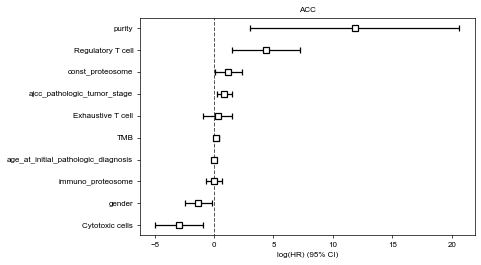

LIHC.tsv


<lifelines.CoxPHFitter: fitted with 327 total observations, 219 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 327
number of events observed = 108
   partial log-likelihood = -519.27
         time fit was run = 2022-08-29 12:29:14 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.30       1.35       0.20            -0.10             0.70                 0.91                 2.01
immuno_proteosome                     0.08       1.09       0.13            -0.17             0.33                 0.85                 1.40
Regulatory T cell                     0.64       1.90       0.43            -0.20             1.48                 0.82                 4.40
Exhaustive T cell                     0.33       1.39       0.26            -0.18             0.83                 0.84                 2.29
Cytotoxic cells                      -1.39       0.25       0.34            -2.05            -0.73                 0.13                 0.48
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.03
gender                                0.29       1.34       0.21            -0.12             0.71                 0.88                 2.03
ajcc_pathologic_tumor_stage           0.44       1.55       0.11             0.22             0.66                 1.25                 1.93
TMB                                   0.07       1.07       0.04            -0.01             0.14                 0.99                 1.15
purity                                0.61       1.85       0.63            -0.63             1.86                 0.53                 6.41

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     1.48   0.14       2.86
immuno_proteosome                    0.66   0.51       0.97
Regulatory T cell                    1.50   0.13       2.91
Exhaustive T cell                    1.27   0.20       2.30
Cytotoxic cells                     -4.10 <0.005      14.59
age_at_initial_pathologic_diagnosis  1.16   0.24       2.03
gender                               1.37   0.17       2.56
ajcc_pathologic_tumor_stage          3.96 <0.005      13.72
TMB                                  1.78   0.07       3.75
purity                               0.97   0.33       1.59
---
Concordance = 0.50
Partial AIC = 1058.54
log-likelihood ratio test = 50.27 on 10 df
-log2(p) of ll-ratio test = 22.01

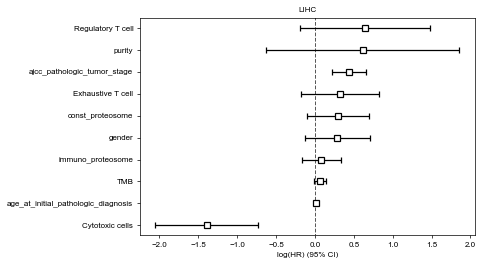

MESO.tsv


<lifelines.CoxPHFitter: fitted with 80 total observations, 12 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 80
number of events observed = 68
   partial log-likelihood = -229.77
         time fit was run = 2022-08-29 12:29:14 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      1.05       2.86       0.39             0.28             1.82                 1.32                 6.17
immuno_proteosome                    -0.80       0.45       0.27            -1.33            -0.27                 0.26                 0.76
Regulatory T cell                     0.35       1.42       0.43            -0.48             1.19                 0.62                 3.27
Exhaustive T cell                     0.37       1.45       0.32            -0.26             1.00                 0.77                 2.71
Cytotoxic cells                      -0.59       0.55       0.49            -1.56             0.38                 0.21                 1.46
age_at_initial_pathologic_diagnosis   0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
gender                                0.50       1.65       0.34            -0.17             1.18                 0.84                 3.25
ajcc_pathologic_tumor_stage          -0.14       0.87       0.15            -0.44             0.15                 0.64                 1.17
TMB                                   0.08       1.08       0.18            -0.28             0.43                 0.75                 1.54
purity                               -2.06       0.13       0.77            -3.57            -0.55                 0.03                 0.57

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     2.67   0.01       7.04
immuno_proteosome                   -2.98 <0.005       8.44
Regulatory T cell                    0.83   0.41       1.30
Exhaustive T cell                    1.16   0.25       2.01
Cytotoxic cells                     -1.20   0.23       2.12
age_at_initial_pathologic_diagnosis  0.12   0.90       0.15
gender                               1.46   0.14       2.80
ajcc_pathologic_tumor_stage         -0.95   0.34       1.55
TMB                                  0.42   0.68       0.56
purity                              -2.68   0.01       7.09
---
Concordance = 0.65
Partial AIC = 479.54
log-likelihood ratio test = 23.78 on 10 df
-log2(p) of ll-ratio test = 6.93

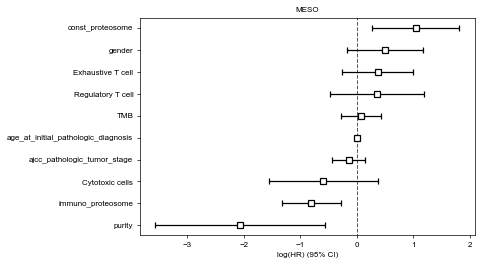

STAD.tsv


<lifelines.CoxPHFitter: fitted with 359 total observations, 224 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 359
number of events observed = 135
   partial log-likelihood = -676.85
         time fit was run = 2022-08-29 12:29:16 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.10       1.11       0.21            -0.30             0.51                 0.74                 1.67
immuno_proteosome                    -0.06       0.95       0.14            -0.33             0.22                 0.72                 1.24
Regulatory T cell                     0.35       1.42       0.32            -0.28             0.98                 0.75                 2.66
Exhaustive T cell                    -0.34       0.71       0.29            -0.90             0.22                 0.41                 1.24
Cytotoxic cells                       0.33       1.39       0.41            -0.48             1.13                 0.62                 3.10
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
gender                                0.01       1.01       0.20            -0.38             0.39                 0.69                 1.47
ajcc_pathologic_tumor_stage           0.63       1.88       0.12             0.40             0.86                 1.49                 2.37
TMB                                  -0.03       0.97       0.01            -0.05            -0.00                 0.95                 1.00
purity                               -0.26       0.77       0.54            -1.32             0.79                 0.27                 2.21

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     0.50   0.62       0.70
immuno_proteosome                   -0.40   0.69       0.54
Regulatory T cell                    1.08   0.28       1.83
Exhaustive T cell                   -1.20   0.23       2.11
Cytotoxic cells                      0.80   0.42       1.24
age_at_initial_pathologic_diagnosis  3.40 <0.005      10.55
gender                               0.03   0.98       0.03
ajcc_pathologic_tumor_stage          5.34 <0.005      23.38
TMB                                 -2.23   0.03       5.27
purity                              -0.48   0.63       0.67
---
Concordance = 0.68
Partial AIC = 1373.70
log-likelihood ratio test = 53.93 on 10 df
-log2(p) of ll-ratio test = 24.26

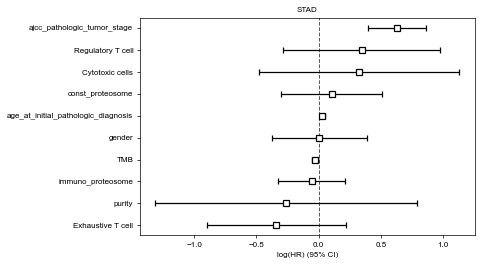

ESCA.tsv


<lifelines.CoxPHFitter: fitted with 141 total observations, 85 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 56
   partial log-likelihood = -210.45
         time fit was run = 2022-08-29 12:29:17 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.05       1.05       0.31            -0.56             0.66                 0.57                 1.93
immuno_proteosome                     0.00       1.00       0.20            -0.39             0.39                 0.68                 1.48
Regulatory T cell                     0.47       1.60       0.48            -0.46             1.41                 0.63                 4.08
Exhaustive T cell                    -0.02       0.98       0.53            -1.07             1.03                 0.34                 2.80
Cytotoxic cells                       0.88       2.41       0.71            -0.51             2.26                 0.60                 9.60
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.01             0.04                 0.99                 1.04
gender                               -0.47       0.63       0.50            -1.44             0.50                 0.24                 1.65
ajcc_pathologic_tumor_stage           0.86       2.36       0.20             0.46             1.25                 1.59                 3.49
TMB                                  -0.00       1.00       0.03            -0.07             0.06                 0.93                 1.06
purity                                2.53      12.50       1.11             0.36             4.69                 1.43               109.07

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     0.16   0.87       0.20
immuno_proteosome                    0.01   0.99       0.01
Regulatory T cell                    0.99   0.32       1.64
Exhaustive T cell                   -0.03   0.97       0.04
Cytotoxic cells                      1.24   0.21       2.23
age_at_initial_pathologic_diagnosis  1.10   0.27       1.89
gender                              -0.94   0.35       1.53
ajcc_pathologic_tumor_stage          4.27 <0.005      15.67
TMB                                 -0.11   0.91       0.13
purity                               2.28   0.02       5.49
---
Concordance = 0.68
Partial AIC = 440.90
log-likelihood ratio test = 28.62 on 10 df
-log2(p) of ll-ratio test = 9.44

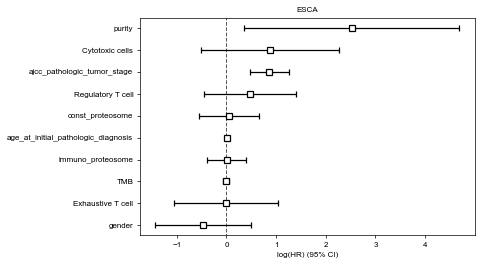

HNSC.tsv


<lifelines.CoxPHFitter: fitted with 421 total observations, 243 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 421
number of events observed = 178
   partial log-likelihood = -924.77
         time fit was run = 2022-08-29 12:29:19 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.00       1.00       0.18            -0.35             0.36                 0.70                 1.43
immuno_proteosome                     0.22       1.24       0.13            -0.03             0.46                 0.97                 1.59
Regulatory T cell                     0.45       1.57       0.33            -0.20             1.09                 0.82                 2.99
Exhaustive T cell                    -0.45       0.64       0.29            -1.03             0.13                 0.36                 1.13
Cytotoxic cells                      -0.52       0.59       0.35            -1.22             0.17                 0.30                 1.18
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
gender                                0.23       1.26       0.17            -0.11             0.57                 0.90                 1.77
ajcc_pathologic_tumor_stage           0.38       1.47       0.10             0.19             0.57                 1.21                 1.78
TMB                                   0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
purity                                0.67       1.96       0.52            -0.35             1.69                 0.70                 5.43

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     0.02   0.99       0.02
immuno_proteosome                    1.73   0.08       3.59
Regulatory T cell                    1.37   0.17       2.54
Exhaustive T cell                   -1.53   0.13       2.99
Cytotoxic cells                     -1.48   0.14       2.86
age_at_initial_pathologic_diagnosis  3.46 <0.005      10.87
gender                               1.35   0.18       2.49
ajcc_pathologic_tumor_stage          3.96 <0.005      13.70
TMB                                  0.07   0.94       0.08
purity                               1.29   0.20       2.33
---
Concordance = 0.50
Partial AIC = 1869.55
log-likelihood ratio test = 42.56 on 10 df
-log2(p) of ll-ratio test = 17.36

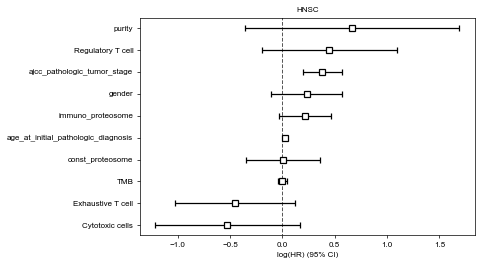

COAD.tsv


<lifelines.CoxPHFitter: fitted with 259 total observations, 199 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 259
number of events observed = 60
   partial log-likelihood = -262.73
         time fit was run = 2022-08-29 12:29:20 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.35       1.42       0.46            -0.55             1.26                 0.58                 3.52
immuno_proteosome                    -0.35       0.70       0.26            -0.86             0.16                 0.42                 1.17
Regulatory T cell                     0.26       1.30       0.54            -0.80             1.33                 0.45                 3.76
Exhaustive T cell                     0.16       1.17       0.50            -0.82             1.14                 0.44                 3.13
Cytotoxic cells                       0.44       1.55       0.73            -0.98             1.86                 0.37                 6.43
age_at_initial_pathologic_diagnosis   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
gender                               -0.27       0.76       0.28            -0.83             0.28                 0.44                 1.33
ajcc_pathologic_tumor_stage           0.98       2.66       0.19             0.61             1.34                 1.85                 3.83
TMB                                   0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
purity                               -0.01       0.99       0.84            -1.65             1.64                 0.19                 5.13

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     0.77   0.44       1.18
immuno_proteosome                   -1.35   0.18       2.50
Regulatory T cell                    0.48   0.63       0.67
Exhaustive T cell                    0.32   0.75       0.42
Cytotoxic cells                      0.60   0.55       0.88
age_at_initial_pathologic_diagnosis  3.03 <0.005       8.68
gender                              -0.96   0.34       1.56
ajcc_pathologic_tumor_stage          5.25 <0.005      22.63
TMB                                  0.41   0.68       0.56
purity                              -0.01   0.99       0.01
---
Concordance = 0.50
Partial AIC = 545.45
log-likelihood ratio test = 39.15 on 10 df
-log2(p) of ll-ratio test = 15.35

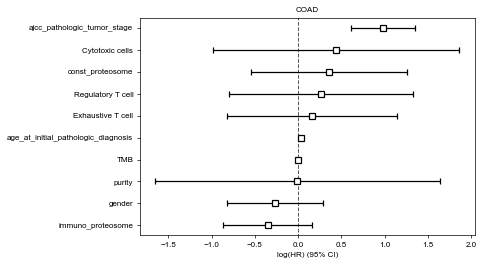

PAAD.tsv


<lifelines.CoxPHFitter: fitted with 141 total observations, 59 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 141
number of events observed = 82
   partial log-likelihood = -330.39
         time fit was run = 2022-08-29 12:29:21 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.09       1.10       0.36            -0.61             0.80                 0.54                 2.22
immuno_proteosome                     0.28       1.32       0.29            -0.29             0.85                 0.75                 2.34
Regulatory T cell                     0.17       1.18       0.44            -0.71             1.04                 0.49                 2.82
Exhaustive T cell                    -0.22       0.80       0.36            -0.92             0.47                 0.40                 1.61
Cytotoxic cells                       0.30       1.35       0.46            -0.60             1.20                 0.55                 3.31
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
gender                                0.20       1.23       0.25            -0.29             0.70                 0.75                 2.00
ajcc_pathologic_tumor_stage          -0.12       0.89       0.25            -0.61             0.37                 0.55                 1.45
TMB                                   0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
purity                               -1.00       0.37       0.54            -2.06             0.06                 0.13                 1.06

                                        z    p   -log2(p)
covariate                                                
const_proteosome                     0.26 0.80       0.33
immuno_proteosome                    0.97 0.33       1.58
Regulatory T cell                    0.37 0.71       0.49
Exhaustive T cell                   -0.62 0.53       0.91
Cytotoxic cells                      0.65 0.51       0.96
age_at_initial_pathologic_diagnosis  1.06 0.29       1.79
gender                               0.81 0.42       1.26
ajcc_pathologic_tumor_stage         -0.47 0.63       0.66
TMB                                  0.08 0.94       0.09
purity                              -1.85 0.06       3.97
---
Concordance = 0.50
Partial AIC = 680.78
log-likelihood ratio test = 10.27 on 10 df
-log2(p) of ll-ratio test = 1.26

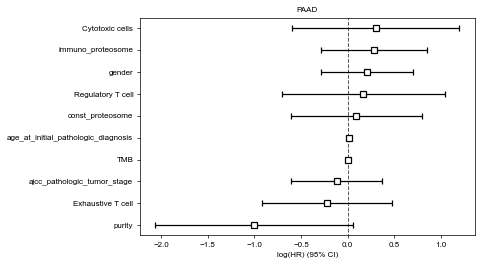

UVM.tsv


<lifelines.CoxPHFitter: fitted with 79 total observations, 57 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 79
number of events observed = 22
   partial log-likelihood = -62.71
         time fit was run = 2022-08-29 12:29:22 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.92       2.51       1.13            -1.29             3.13                 0.27                22.87
immuno_proteosome                    -0.00       1.00       0.37            -0.73             0.72                 0.48                 2.05
Regulatory T cell                    -1.24       0.29       1.02            -3.25             0.77                 0.04                 2.16
Exhaustive T cell                     2.30      10.00       0.88             0.58             4.02                 1.79                55.80
Cytotoxic cells                       0.53       1.70       0.97            -1.37             2.43                 0.26                11.31
age_at_initial_pathologic_diagnosis   0.06       1.06       0.02             0.01             0.11                 1.01                 1.11
gender                               -0.04       0.96       0.51            -1.04             0.96                 0.35                 2.60
ajcc_pathologic_tumor_stage           1.56       4.75       0.54             0.51             2.61                 1.66                13.63
TMB                                  -0.24       0.79       0.92            -2.03             1.56                 0.13                 4.74
purity                                4.36      78.17       2.61            -0.76             9.47                 0.47             13018.47

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     0.81   0.42       1.27
immuno_proteosome                   -0.01   0.99       0.01
Regulatory T cell                   -1.21   0.23       2.14
Exhaustive T cell                    2.63   0.01       6.85
Cytotoxic cells                      0.55   0.58       0.78
age_at_initial_pathologic_diagnosis  2.41   0.02       5.97
gender                              -0.08   0.93       0.10
ajcc_pathologic_tumor_stage          2.90 <0.005       8.08
TMB                                 -0.26   0.79       0.33
purity                               1.67   0.09       3.40
---
Concordance = 0.84
Partial AIC = 145.43
log-likelihood ratio test = 33.92 on 10 df
-log2(p) of ll-ratio test = 12.36

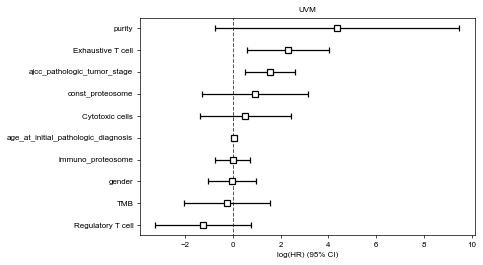

SARC.tsv
LUSC.tsv


<lifelines.CoxPHFitter: fitted with 447 total observations, 253 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 447
number of events observed = 194
   partial log-likelihood = -995.82
         time fit was run = 2022-08-29 12:29:24 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                     -0.07       0.94       0.18            -0.42             0.29                 0.65                 1.34
immuno_proteosome                     0.14       1.15       0.12            -0.10             0.37                 0.91                 1.45
Regulatory T cell                     0.73       2.08       0.29             0.16             1.30                 1.18                 3.67
Exhaustive T cell                    -0.21       0.81       0.28            -0.76             0.35                 0.47                 1.42
Cytotoxic cells                      -0.09       0.92       0.38            -0.84             0.67                 0.43                 1.95
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.00             0.03                 1.00                 1.04
gender                               -0.22       0.80       0.17            -0.55             0.12                 0.57                 1.13
ajcc_pathologic_tumor_stage           0.26       1.29       0.09             0.09             0.43                 1.09                 1.53
TMB                                  -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
purity                                0.45       1.57       0.49            -0.51             1.41                 0.60                 4.09

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                    -0.37   0.71       0.48
immuno_proteosome                    1.13   0.26       1.96
Regulatory T cell                    2.51   0.01       6.39
Exhaustive T cell                   -0.73   0.47       1.10
Cytotoxic cells                     -0.22   0.82       0.28
age_at_initial_pathologic_diagnosis  1.91   0.06       4.15
gender                              -1.27   0.20       2.29
ajcc_pathologic_tumor_stage          2.96 <0.005       8.33
TMB                                 -0.39   0.69       0.53
purity                               0.92   0.36       1.49
---
Concordance = 0.62
Partial AIC = 2011.65
log-likelihood ratio test = 24.76 on 10 df
-log2(p) of ll-ratio test = 7.42

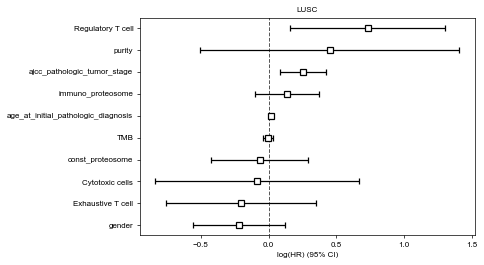

BLCA.tsv


<lifelines.CoxPHFitter: fitted with 390 total observations, 218 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 390
number of events observed = 172
   partial log-likelihood = -868.58
         time fit was run = 2022-08-29 12:29:26 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.36       1.43       0.20            -0.02             0.75                 0.98                 2.11
immuno_proteosome                    -0.25       0.78       0.11            -0.47            -0.03                 0.63                 0.97
Regulatory T cell                     0.90       2.46       0.33             0.25             1.55                 1.28                 4.72
Exhaustive T cell                    -0.08       0.93       0.31            -0.68             0.53                 0.50                 1.71
Cytotoxic cells                      -0.03       0.97       0.37            -0.75             0.69                 0.47                 1.99
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
gender                                0.09       1.10       0.17            -0.25             0.43                 0.78                 1.54
ajcc_pathologic_tumor_stage           0.40       1.50       0.10             0.20             0.60                 1.23                 1.83
TMB                                  -0.09       0.91       0.03            -0.15            -0.04                 0.86                 0.96
purity                                0.17       1.19       0.47            -0.75             1.10                 0.47                 3.01

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     1.84   0.07       3.93
immuno_proteosome                   -2.20   0.03       5.15
Regulatory T cell                    2.71   0.01       7.24
Exhaustive T cell                   -0.24   0.81       0.31
Cytotoxic cells                     -0.09   0.93       0.10
age_at_initial_pathologic_diagnosis  2.63   0.01       6.88
gender                               0.54   0.59       0.76
ajcc_pathologic_tumor_stage          3.95 <0.005      13.65
TMB                                 -3.52 <0.005      11.19
purity                               0.37   0.71       0.49
---
Concordance = 0.71
Partial AIC = 1757.16
log-likelihood ratio test = 85.18 on 10 df
-log2(p) of ll-ratio test = 44.24

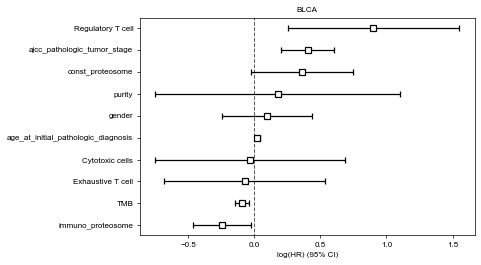

LGG.tsv
CHOL.tsv


<lifelines.CoxPHFitter: fitted with 36 total observations, 18 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 36
number of events observed = 18
   partial log-likelihood = -46.82
         time fit was run = 2022-08-29 12:29:28 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      1.19       3.29       0.75            -0.29             2.67                 0.75                14.40
immuno_proteosome                    -0.08       0.92       0.40            -0.87             0.70                 0.42                 2.02
Regulatory T cell                    -0.65       0.52       1.09            -2.79             1.48                 0.06                 4.41
Exhaustive T cell                     0.83       2.30       0.95            -1.03             2.70                 0.36                14.89
Cytotoxic cells                      -2.16       0.12       1.00            -4.13            -0.19                 0.02                 0.83
age_at_initial_pathologic_diagnosis  -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
gender                                0.34       1.41       0.70            -1.04             1.72                 0.35                 5.60
ajcc_pathologic_tumor_stage           0.29       1.34       0.23            -0.15             0.74                 0.86                 2.09
TMB                                   0.31       1.36       0.14             0.03             0.58                 1.04                 1.79
purity                               -2.92       0.05       2.27            -7.38             1.54                 0.00                 4.66

                                        z    p   -log2(p)
covariate                                                
const_proteosome                     1.58 0.11       3.13
immuno_proteosome                   -0.21 0.84       0.26
Regulatory T cell                   -0.60 0.55       0.86
Exhaustive T cell                    0.88 0.38       1.39
Cytotoxic cells                     -2.15 0.03       4.99
age_at_initial_pathologic_diagnosis -0.39 0.70       0.52
gender                               0.49 0.63       0.68
ajcc_pathologic_tumor_stage          1.29 0.20       2.33
TMB                                  2.21 0.03       5.19
purity                              -1.28 0.20       2.33
---
Concordance = 0.72
Partial AIC = 113.64
log-likelihood ratio test = 11.42 on 10 df
-log2(p) of ll-ratio test = 1.62

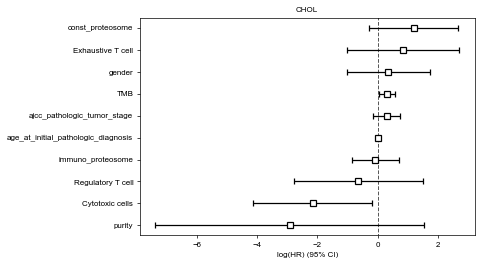

LAML.tsv
GBM.tsv
SKCM.tsv


<lifelines.CoxPHFitter: fitted with 377 total observations, 209 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 377
number of events observed = 168
   partial log-likelihood = -799.86
         time fit was run = 2022-08-29 12:29:31 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.59       1.81       0.18             0.24             0.94                 1.28                 2.56
immuno_proteosome                    -0.02       0.98       0.11            -0.24             0.20                 0.78                 1.22
Regulatory T cell                     0.48       1.62       0.36            -0.23             1.19                 0.80                 3.30
Exhaustive T cell                    -1.29       0.27       0.32            -1.93            -0.66                 0.15                 0.52
Cytotoxic cells                       0.63       1.88       0.36            -0.08             1.34                 0.92                 3.82
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.01             0.03                 1.01                 1.03
gender                               -0.19       0.82       0.18            -0.54             0.15                 0.58                 1.17
ajcc_pathologic_tumor_stage           0.46       1.58       0.10             0.26             0.66                 1.29                 1.93
TMB                                  -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
purity                                0.55       1.73       0.46            -0.35             1.44                 0.71                 4.24

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     3.34 <0.005      10.20
immuno_proteosome                   -0.19   0.85       0.24
Regulatory T cell                    1.33   0.18       2.45
Exhaustive T cell                   -4.02 <0.005      14.07
Cytotoxic cells                      1.74   0.08       3.62
age_at_initial_pathologic_diagnosis  3.54 <0.005      11.26
gender                              -1.09   0.27       1.87
ajcc_pathologic_tumor_stage          4.48 <0.005      17.02
TMB                                 -0.45   0.65       0.62
purity                               1.20   0.23       2.12
---
Concordance = 0.50
Partial AIC = 1619.73
log-likelihood ratio test = 81.85 on 10 df
-log2(p) of ll-ratio test = 42.06

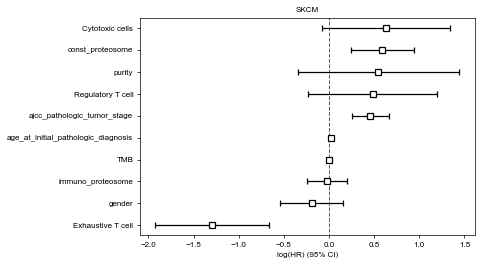

KIRP.tsv


<lifelines.CoxPHFitter: fitted with 244 total observations, 210 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 34
   partial log-likelihood = -136.36
         time fit was run = 2022-08-29 12:29:32 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                     -0.66       0.52       0.63            -1.90             0.58                 0.15                 1.78
immuno_proteosome                    -0.64       0.53       0.41            -1.45             0.17                 0.23                 1.19
Regulatory T cell                     0.32       1.37       0.77            -1.20             1.83                 0.30                 6.24
Exhaustive T cell                     1.17       3.22       0.50             0.20             2.14                 1.22                 8.52
Cytotoxic cells                       0.51       1.66       0.77            -1.00             2.01                 0.37                 7.48
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
gender                                0.17       1.19       0.42            -0.66             1.00                 0.52                 2.72
ajcc_pathologic_tumor_stage           1.12       3.08       0.19             0.76             1.49                 2.14                 4.43
TMB                                  -0.17       0.84       0.14            -0.45             0.11                 0.64                 1.12
purity                                1.42       4.15       1.49            -1.49             4.34                 0.23                76.46

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                    -1.05   0.29       1.76
immuno_proteosome                   -1.54   0.12       3.02
Regulatory T cell                    0.41   0.68       0.55
Exhaustive T cell                    2.36   0.02       5.78
Cytotoxic cells                      0.66   0.51       0.97
age_at_initial_pathologic_diagnosis  1.02   0.31       1.69
gender                               0.40   0.69       0.54
ajcc_pathologic_tumor_stage          6.04 <0.005      29.30
TMB                                 -1.18   0.24       2.08
purity                               0.96   0.34       1.56
---
Concordance = 0.50
Partial AIC = 292.73
log-likelihood ratio test = 51.42 on 10 df
-log2(p) of ll-ratio test = 22.71

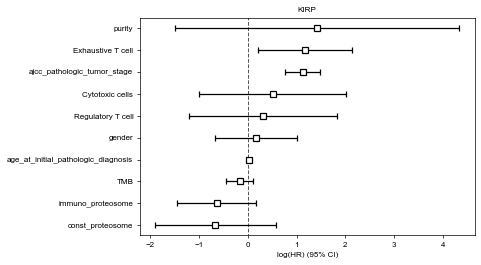

BRCA.tsv


<lifelines.CoxPHFitter: fitted with 961 total observations, 836 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 961
number of events observed = 125
   partial log-likelihood = -658.58
         time fit was run = 2022-08-29 12:29:36 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.17       1.18       0.23            -0.29             0.62                 0.75                 1.86
immuno_proteosome                    -0.26       0.77       0.15            -0.54             0.03                 0.58                 1.03
Regulatory T cell                     1.20       3.32       0.37             0.47             1.92                 1.61                 6.85
Exhaustive T cell                    -0.14       0.87       0.30            -0.73             0.45                 0.48                 1.57
Cytotoxic cells                      -0.08       0.92       0.40            -0.86             0.70                 0.42                 2.01
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
gender                                0.13       1.13       1.01            -1.85             2.10                 0.16                 8.17
ajcc_pathologic_tumor_stage           0.74       2.10       0.12             0.51             0.97                 1.67                 2.64
TMB                                   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
purity                               -0.14       0.87       0.64            -1.39             1.11                 0.25                 3.02

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     0.71   0.48       1.07
immuno_proteosome                   -1.78   0.08       3.72
Regulatory T cell                    3.24 <0.005       9.70
Exhaustive T cell                   -0.46   0.65       0.63
Cytotoxic cells                     -0.20   0.84       0.25
age_at_initial_pathologic_diagnosis  4.59 <0.005      17.78
gender                               0.13   0.90       0.15
ajcc_pathologic_tumor_stage          6.32 <0.005      31.79
TMB                                  2.74   0.01       7.34
purity                              -0.22   0.82       0.28
---
Concordance = 0.50
Partial AIC = 1337.17
log-likelihood ratio test = 77.28 on 10 df
-log2(p) of ll-ratio test = 39.09

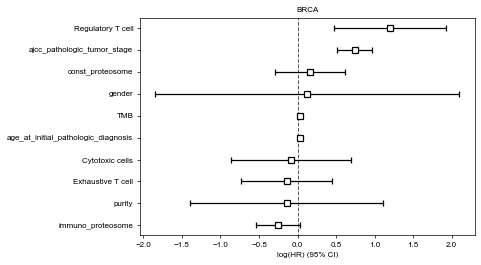

KIRC.tsv


<lifelines.CoxPHFitter: fitted with 342 total observations, 251 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 342
number of events observed = 91
   partial log-likelihood = -423.33
         time fit was run = 2022-08-29 12:29:39 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.50       1.64       0.32            -0.13             1.13                 0.87                 3.08
immuno_proteosome                     0.11       1.12       0.24            -0.36             0.59                 0.69                 1.81
Regulatory T cell                    -0.35       0.70       0.46            -1.25             0.54                 0.29                 1.72
Exhaustive T cell                    -0.19       0.83       0.30            -0.77             0.39                 0.47                 1.48
Cytotoxic cells                      -0.50       0.60       0.42            -1.32             0.31                 0.27                 1.37
age_at_initial_pathologic_diagnosis   0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
gender                                0.02       1.02       0.23            -0.44             0.48                 0.65                 1.61
ajcc_pathologic_tumor_stage           0.70       2.01       0.11             0.49             0.91                 1.64                 2.48
TMB                                   0.22       1.25       0.08             0.08             0.37                 1.08                 1.45
purity                               -1.10       0.33       0.88            -2.82             0.62                 0.06                 1.85

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     1.54   0.12       3.03
immuno_proteosome                    0.47   0.64       0.65
Regulatory T cell                   -0.77   0.44       1.19
Exhaustive T cell                   -0.63   0.53       0.93
Cytotoxic cells                     -1.21   0.23       2.13
age_at_initial_pathologic_diagnosis  4.46 <0.005      16.90
gender                               0.09   0.93       0.11
ajcc_pathologic_tumor_stage          6.65 <0.005      35.03
TMB                                  2.97 <0.005       8.41
purity                              -1.26   0.21       2.26
---
Concordance = 0.50
Partial AIC = 866.66
log-likelihood ratio test = 91.50 on 10 df
-log2(p) of ll-ratio test = 48.40

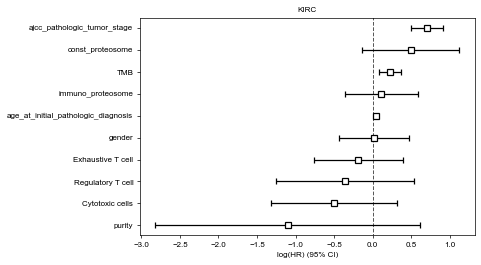

LUAD.tsv


<lifelines.CoxPHFitter: fitted with 474 total observations, 309 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 474
number of events observed = 165
   partial log-likelihood = -843.86
         time fit was run = 2022-08-29 12:29:41 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      0.52       1.69       0.19             0.15             0.89                 1.17                 2.44
immuno_proteosome                     0.15       1.16       0.12            -0.10             0.39                 0.91                 1.48
Regulatory T cell                     0.02       1.02       0.34            -0.64             0.68                 0.53                 1.97
Exhaustive T cell                    -0.06       0.94       0.27            -0.59             0.47                 0.55                 1.61
Cytotoxic cells                      -0.54       0.58       0.33            -1.19             0.11                 0.31                 1.11
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
gender                                0.14       1.15       0.17            -0.18             0.47                 0.83                 1.59
ajcc_pathologic_tumor_stage           0.53       1.69       0.08             0.38             0.68                 1.46                 1.97
TMB                                   0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
purity                                0.68       1.98       0.55            -0.40             1.77                 0.67                 5.88

                                        z      p   -log2(p)
covariate                                                  
const_proteosome                     2.78   0.01       7.51
immuno_proteosome                    1.18   0.24       2.08
Regulatory T cell                    0.05   0.96       0.06
Exhaustive T cell                   -0.22   0.83       0.27
Cytotoxic cells                     -1.63   0.10       3.28
age_at_initial_pathologic_diagnosis  1.98   0.05       4.39
gender                               0.85   0.40       1.33
ajcc_pathologic_tumor_stage          6.92 <0.005      37.67
TMB                                  0.17   0.87       0.20
purity                               1.23   0.22       2.20
---
Concordance = 0.50
Partial AIC = 1707.72
log-likelihood ratio test = 64.22 on 10 df
-log2(p) of ll-ratio test = 30.71

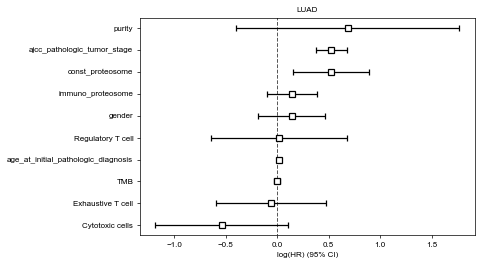

READ.tsv


<lifelines.CoxPHFitter: fitted with 80 total observations, 66 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 80
number of events observed = 14
   partial log-likelihood = -35.65
         time fit was run = 2022-08-29 12:29:41 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
const_proteosome                      2.44      11.51       1.13             0.22             4.67                 1.25               106.29
immuno_proteosome                    -1.18       0.31       0.76            -2.66             0.31                 0.07                 1.37
Regulatory T cell                     3.45      31.49       1.66             0.20             6.70                 1.22               810.27
Exhaustive T cell                     1.01       2.74       1.33            -1.59             3.61                 0.20                37.09
Cytotoxic cells                      -0.18       0.83       1.85            -3.80             3.44                 0.02                31.05
age_at_initial_pathologic_diagnosis   0.10       1.11       0.04             0.02             0.18                 1.02                 1.20
gender                               -0.10       0.91       0.85            -1.77             1.58                 0.17                 4.84
ajcc_pathologic_tumor_stage           0.39       1.48       0.41            -0.41             1.19                 0.66                 3.30
TMB                                  -0.07       0.94       0.17            -0.40             0.27                 0.67                 1.31
purity                                5.53     251.66       3.15            -0.65            11.70                 0.52             1.21e+05

                                        z    p   -log2(p)
covariate                                                
const_proteosome                     2.15 0.03       5.00
immuno_proteosome                   -1.55 0.12       3.04
Regulatory T cell                    2.08 0.04       4.74
Exhaustive T cell                    0.76 0.45       1.16
Cytotoxic cells                     -0.10 0.92       0.12
age_at_initial_pathologic_diagnosis  2.56 0.01       6.56
gender                              -0.11 0.91       0.14
ajcc_pathologic_tumor_stage          0.95 0.34       1.56
TMB                                 -0.38 0.70       0.51
purity                               1.75 0.08       3.66
---
Concordance = 0.85
Partial AIC = 91.29
log-likelihood ratio test = 25.13 on 10 df
-log2(p) of ll-ratio test = 7.62

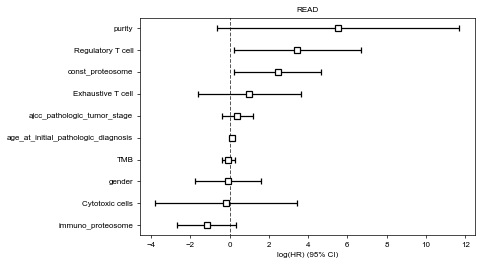

In [26]:
######## tumor purity information####################################################################
tumor_purity_df=pd.read_csv("/workspace/projects/immunoproteasome/data/purity_data/TCGA_mastercalls.abs_tables_JSedit.fixed.txt",sep='\t')
tumor_purity_df['sample_id']=tumor_purity_df['array'].str.split('-').str[0:3].str.join('.')
tumor_purity_df=tumor_purity_df[['purity','sample_id']]
tumor_purity_df=tumor_purity_df.set_index('sample_id')
#### Mutational file ##############################################################################
tumor_mutation_df = pd.read_csv('/workspace/projects/immunoproteasome/data/tcga_cohort.txt', sep="\t",header = 0)
tumor_mutation_df['TMB']=tumor_mutation_df['total']/50
tumor_mutation_df['Tumor_Sample_Barcode']=tumor_mutation_df['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('.')
tumor_mutation_df=tumor_mutation_df.set_index('Tumor_Sample_Barcode')
######### stage age gender included into the list of variables####################################
xls_1 = pd.ExcelFile('/workspace/shared/dataset/tcga_exome/tcga_cdr/mmc1.xlsx')
df_1 = xls_1.parse(0)
df_age_sex_grade_info=df_1[['bcr_patient_barcode','type','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','OS','OS.time']]
df_age_sex_grade_info['bcr_patient_barcode']=df_age_sex_grade_info['bcr_patient_barcode'].str.split('-').str[0:3].str.join('.')
df_age_sex_grade_info=df_age_sex_grade_info.set_index('bcr_patient_barcode')
df_age_sex_grade_info['gender']=df_age_sex_grade_info['gender'].replace(['MALE','FEMALE'],[1,2])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage IA','Stage IB','Stage IIA','Stage IIB','Stage IIC','Stage IIIA','Stage IIIB','Stage IIIC','Stage IVA','Stage IVB','Stage IVC'],['Stage I','Stage I','Stage II','Stage II','Stage II','Stage III','Stage III','Stage III','Stage IV','Stage IV','Stage IV'])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage I','Stage II','Stage III','Stage IV'],[1,2,3,4])
##################################################################################################

input_path1="/workspace/projects/immunoproteasome/data/tcga_tumor/"
input_path3="/workspace/projects/immunoproteasome/v1_copy_4/03_output/"
cytotoxic_hazard_summary=[]
tumor_tissue1=[]

tumor_tissue.remove('UCS.tsv')
tumor_tissue.remove('OV.tsv')
tumor_tissue.remove('CESC.tsv')
tumor_tissue.remove('PRAD.tsv')
tumor_tissue.remove('UCEC.tsv')

for i in range(len(tumor_tissue)):
    print(tumor_tissue[i])
    gene_data_frame=pd.read_csv(input_path1+tumor_tissue[i],sep='\t',index_col=0)
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame=gene_data_frame.T+1
    
    log_gene_data_frame=np.log2(gene_data_frame)
    log_gene_data_frame['const_proteosome']=(1/3)*(log_gene_data_frame['PSMB5']+log_gene_data_frame['PSMB6']+log_gene_data_frame['PSMB7'])
    log_gene_data_frame['immuno_proteosome']=(1/3)*(log_gene_data_frame['PSMB8']+log_gene_data_frame['PSMB9']+log_gene_data_frame['PSMB10'])
    
    immune_gsva_score=pd.read_csv(input_path3+'GSVA_'+'immune_cells_'+tumor_tissue[i],sep='\t')
    
    df3=pd.merge(log_gene_data_frame[['const_proteosome','immuno_proteosome']],immune_gsva_score.T,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score1=pd.merge(df3,tumor_purity_df,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score2=pd.merge(df_age_sex_grade_info,df_immunogenicity_proteasome_immune_cells_score1,left_index=True, right_index=True)
    df_immunogenicity_proteasome_immune_cells_score3=pd.merge(tumor_mutation_df,df_immunogenicity_proteasome_immune_cells_score2,left_index=True, right_index=True)
    
    #variables=['const_proteosome','Regulatory T cell','Cytotoxic cells','Exhaustive T cell','OS', 'OS.time']
    variables=['const_proteosome','immuno_proteosome','Regulatory T cell','Exhaustive T cell','Cytotoxic cells','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','TMB','purity','OS', 'OS.time']
    #-------- keep immuno_proteaosme and change the other varaible iteratively to collect the HR ratio
    #df_subset=df_immunogenicity_proteasome_immune_cells_score3[['const_proteosome','ajcc_pathologic_tumor_stage','OS','OS.time']] ### Put different varaible along with Immunoproteasome score
    df_subset=df_immunogenicity_proteasome_immune_cells_score3[variables]
    #-------------------------------------------------------------------------------------------------------------------
    df_subset=df_subset.dropna()
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Not Available]'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Discrepancy]'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Unknown]'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='I/II NOS'].index)
    df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='Stage X'].index)
    
    try:
        cph = CoxPHFitter()
        cph.fit(df_subset, duration_col='OS.time', event_col='OS')
        cph.print_summary()
        cytotoxic_hazard_summary.append(list(cph.summary.iloc[0]))
        tumor_tissue1.append(tumor_tissue[i].split('.')[0])
        cph.plot()
        plt.title(tumor_tissue[i].split('.')[0])
        plt.show()
    except ZeroDivisionError:
        pass

#df_tmp_immuno=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno.index=tumor_tissue1
#df_tmp_immuno['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno['p'])), method = 'BH')
#df_tmp_immuno['error_bar']=np.abs(((df_tmp_immuno['coef upper 95%'])-(df_tmp_immuno['coef lower 95%']))/2)

#df_tmp_immuno_cytox=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_cytox.index=tumor_tissue1
#df_tmp_immuno_cytox['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_cytox['p'])), method = 'BH')
#df_tmp_immuno_cytox['error_bar']=np.abs(((df_tmp_immuno_cytox['coef upper 95%'])-(df_tmp_immuno_cytox['coef lower 95%']))/2)

#df_tmp_immuno_reg=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_reg.index=tumor_tissue1
#df_tmp_immuno_reg['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_reg['p'])), method = 'BH')
#df_tmp_immuno_reg['error_bar']=np.abs(((df_tmp_immuno_reg['coef upper 95%'])-(df_tmp_immuno_reg['coef lower 95%']))/2)

#df_tmp_immuno_Exhausted_T_cell_score=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_Exhausted_T_cell_score.index=tumor_tissue1
#df_tmp_immuno_Exhausted_T_cell_score['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_Exhausted_T_cell_score['p'])), method = 'BH')
#df_tmp_immuno_Exhausted_T_cell_score['error_bar']=np.abs(((df_tmp_immuno_Exhausted_T_cell_score['coef upper 95%'])-(df_tmp_immuno_Exhausted_T_cell_score['coef lower 95%']))/2)

#df_tmp_immuno_TMB=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_TMB.index=tumor_tissue1
#df_tmp_immuno_TMB['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_TMB['p'])), method = 'BH')
#df_tmp_immuno_TMB['error_bar']=np.abs(((df_tmp_immuno_TMB['coef upper 95%'])-(df_tmp_immuno_TMB['coef lower 95%']))/2)

#df_tmp_immuno_purity=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_purity.index=tumor_tissue1
#df_tmp_immuno_purity['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_purity['p'])), method = 'BH')
#df_tmp_immuno_purity['error_bar']=np.abs(((df_tmp_immuno_purity['coef upper 95%'])-(df_tmp_immuno_purity['coef lower 95%']))/2)

#df_tmp_immuno_const=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_const.index=tumor_tissue1
#df_tmp_immuno_const['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_const['p'])), method = 'BH')
#df_tmp_immuno_const['error_bar']=np.abs(((df_tmp_immuno_const['coef upper 95%'])-(df_tmp_immuno_const['coef lower 95%']))/2)

#df_tmp_immuno_age=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_age.index=tumor_tissue1
#df_tmp_immuno_age['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_age['p'])), method = 'BH')
#df_tmp_immuno_age['error_bar']=np.abs(((df_tmp_immuno_age['coef upper 95%'])-(df_tmp_immuno_age['coef lower 95%']))/2)

#df_tmp_immuno_gender=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_gender.index=tumor_tissue1
#df_tmp_immuno_gender['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_gender['p'])), method = 'BH')
#df_tmp_immuno_gender['error_bar']=np.abs(((df_tmp_immuno_gender['coef upper 95%'])-(df_tmp_immuno_gender['coef lower 95%']))/2)

#df_tmp_immuno_stage=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
#df_tmp_immuno_stage.index=tumor_tissue1
#df_tmp_immuno_stage['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_stage['p'])), method = 'BH')
#df_tmp_immuno_stage['error_bar']=np.abs(((df_tmp_immuno_stage['coef upper 95%'])-(df_tmp_immuno_stage['coef lower 95%']))/2)

df_tmp_immuno_all=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
df_tmp_immuno_all.index=tumor_tissue1
df_tmp_immuno_all['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno_all['p'])), method = 'BH')
df_tmp_immuno_all['error_bar']=np.abs(((df_tmp_immuno_all['coef upper 95%'])-(df_tmp_immuno_all['coef lower 95%']))/2)


In [27]:
## Creating dataframe of CP hazard ratio with its differnt confounders
df_all_CP_HR=pd.DataFrame()

df_all_CP_HR['CP[log[HR]]']=df_tmp_immuno['coef']
df_all_CP_HR['CP[p_value]']=df_tmp_immuno['p_adjust']

df_all_CP_HR['CP+Cytotoxic score[log[HR]]']=df_tmp_immuno_cytox['coef']
df_all_CP_HR['CP+Cytotoxic score[p_value]']=df_tmp_immuno_cytox['p_adjust']

df_all_CP_HR['CP+T_reg[log[HR]]']=df_tmp_immuno_reg['coef']
df_all_CP_HR['CP+T_reg[p_value]']=df_tmp_immuno_reg['p_adjust']

df_all_CP_HR['CP+Exhausted T cell[log[HR]]']=df_tmp_immuno_Exhausted_T_cell_score['coef']
df_all_CP_HR['CP+Exhausted T cell[p_value]']=df_tmp_immuno_Exhausted_T_cell_score['p_adjust']

df_all_CP_HR['CP+TMB[log[HR]]']=df_tmp_immuno_TMB['coef']
df_all_CP_HR['CP+TMB[p_value]']=df_tmp_immuno_TMB['p_adjust']

df_all_CP_HR['CP+purity[log[HR]]']=df_tmp_immuno_purity['coef']
df_all_CP_HR['CP+purity[p_value]']=df_tmp_immuno_purity['p_adjust']

df_all_CP_HR['CP+IP[log[HR]]']=df_tmp_immuno_const['coef']
df_all_CP_HR['CP+IP[p_value]']=df_tmp_immuno_const['p_adjust']

df_all_CP_HR['CP+age[log[HR]]']=df_tmp_immuno_age['coef']
df_all_CP_HR['CP+age[p_value]']=df_tmp_immuno_age['p_adjust']

df_all_CP_HR['CP+gender[log[HR]]']=df_tmp_immuno_gender['coef']
df_all_CP_HR['CP+gender[p_value]']=df_tmp_immuno_gender['p_adjust']

df_all_CP_HR['CP+stage[log[HR]]']=df_tmp_immuno_stage['coef']
df_all_CP_HR['CP+stage[p_value]']=df_tmp_immuno_stage['p_adjust']


df_all_CP_HR['CP+all[log[HR]]']=df_tmp_immuno_all['coef']
df_all_CP_HR['CP+all[p_value]']=df_tmp_immuno_all['p_adjust']



In [28]:
df_all_CP_HR

,CP[log[HR]],CP[p_value],CP+Cytotoxic score[log[HR]],CP+Cytotoxic score[p_value],CP+T_reg[log[HR]],CP+T_reg[p_value],CP+Exhausted T cell[log[HR]],CP+Exhausted T cell[p_value],CP+TMB[log[HR]],CP+TMB[p_value],...,CP+IP[log[HR]],CP+IP[p_value],CP+age[log[HR]],CP+age[p_value],CP+gender[log[HR]],CP+gender[p_value],CP+stage[log[HR]],CP+stage[p_value],CP+all[log[HR]],CP+all[p_value]
ACC,1.139138,0.059691,0.763739,0.261853,1.009715,0.138332,1.173437,0.043084,1.162180,0.060115,...,1.342631,0.031370,1.380905,0.032025,1.234126,0.038156,1.470154,0.034703,1.203049,0.122892
LIHC,0.046259,0.820668,0.242155,0.399588,0.057962,0.797769,0.043007,0.903065,0.061682,0.810579,...,0.090845,0.804998,0.013667,0.952625,0.050426,0.846070,0.181275,0.620822,0.299964,0.276127
MESO,0.266142,0.628760,0.289323,0.602766,0.180756,0.797769,0.357798,0.521695,0.264293,0.635421,...,0.789798,0.084559,0.237242,0.692902,0.262355,0.593456,0.257885,0.620822,1.049601,0.045590
STAD,0.087977,0.798492,0.100758,0.803435,0.062872,0.797769,0.137908,0.745298,0.222190,0.504855,...,0.173549,0.682799,-0.011239,0.952625,0.107228,0.758575,0.044598,0.811251,0.104250,0.793523
ESCA,0.169650,0.750514,0.162788,0.750095,0.165080,0.797769,0.147095,0.794574,0.187845,0.688593,...,0.159645,0.779854,0.150898,0.757402,0.213604,0.593456,0.105330,0.791552,0.050406,0.922247
UCS,0.247711,0.789901,0.412920,0.602766,0.252922,0.797769,0.209834,0.841806,0.279757,0.700378,...,0.486945,0.644153,0.457332,0.596126,NaN,NaN,NaN,NaN,NaN,NaN
HNSC,0.194978,0.371469,0.229758,0.261853,0.202869,0.373312,0.221992,0.284258,0.193531,0.379589,...,0.267912,0.180408,0.146450,0.560304,0.178432,0.388557,0.128877,0.620822,0.003192,0.985905
OV,-0.211668,0.522078,-0.208079,0.557038,-0.200354,0.556802,-0.225298,0.521695,-0.184467,0.570021,...,-0.181226,0.667059,-0.272188,0.435464,NaN,NaN,NaN,NaN,NaN,NaN
COAD,-0.117969,0.810962,-0.168338,0.828371,-0.087609,0.844561,-0.138219,0.871454,-0.161436,0.810579,...,-0.102635,0.804998,-0.154175,0.797452,-0.179867,0.763111,0.262971,0.681211,0.354156,0.659201
CESC,-0.271659,0.522078,-0.165792,0.750095,-0.311478,0.556802,0.033971,0.903065,-0.272360,0.550387,...,-0.098866,0.804998,-0.241818,0.611031,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
## Selecting the tumor tissues based the significance level of CP's hazard ratio
df_all_CP_HR[(df_all_CP_HR['CP[p_value]']<0.1)|(df_all_CP_HR['CP+Cytotoxic score[p_value]']<0.1)|(df_all_CP_HR['CP+T_reg[p_value]']<0.1)|(df_all_CP_HR['CP+Exhausted T cell[p_value]']<0.1)]

,CP[log[HR]],CP[p_value],CP+Cytotoxic score[log[HR]],CP+Cytotoxic score[p_value],CP+T_reg[log[HR]],CP+T_reg[p_value],CP+Exhausted T cell[log[HR]],CP+Exhausted T cell[p_value],CP+TMB[log[HR]],CP+TMB[p_value],...,CP+IP[log[HR]],CP+IP[p_value],CP+age[log[HR]],CP+age[p_value],CP+gender[log[HR]],CP+gender[p_value],CP+stage[log[HR]],CP+stage[p_value],CP+all[log[HR]],CP+all[p_value]
ACC,1.139138,0.059691,0.763739,0.261853,1.009715,0.138332,1.173437,0.043084,1.162180,0.060115,...,1.342631,0.031370,1.380905,0.032025,1.234126,0.038156,1.470154,0.034703,1.203049,0.122892
BLCA,0.293705,0.263409,0.489715,0.041147,0.157682,0.669724,0.494854,0.043084,0.429394,0.060115,...,0.503045,0.035175,0.211902,0.502020,0.289083,0.227118,0.266496,0.358382,0.360958,0.196754
LGG,-1.476741,0.002216,-1.499012,0.001528,-1.414571,0.002198,-1.477443,0.001176,-1.481484,0.001989,...,-1.671332,0.000019,-1.499031,0.000225,-1.487821,0.001702,NaN,NaN,NaN,NaN
SKCM,0.349905,0.182807,0.404793,0.087012,0.265917,0.349390,0.425542,0.043084,0.351408,0.149533,...,0.423320,0.058309,0.351136,0.128077,0.364878,0.098402,0.470703,0.036395,0.591219,0.015250
KIRC,0.828190,0.006568,0.850867,0.004348,0.897849,0.002198,0.783193,0.014545,0.780144,0.015094,...,0.623241,0.091292,0.790392,0.011489,0.915835,0.002112,0.544491,0.126003,0.495799,0.276127
LUAD,0.464276,0.025469,0.570745,0.004348,0.464447,0.026498,0.504178,0.014545,0.480577,0.017764,...,0.487975,0.030754,0.463140,0.024733,0.466858,0.020343,0.502746,0.034703,0.523272,0.045590


In [32]:
## Generating the supplementray file Table 6B
with pd.ExcelWriter('/workspace/projects/immunoproteasome/supplementary_tables/supple6.xlsx') as writer:  
    df_all_CP_HR.to_excel(writer, sheet_name='Sheet_name_1')

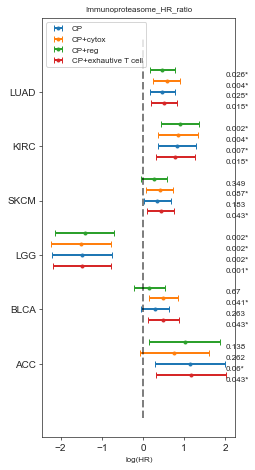

In [33]:
### Plot of CP hazard ratio with its confounders
tt_list=['ACC','BLCA','LGG','SKCM','KIRC','LUAD']

df_tmp_immuno=df_tmp_immuno.sort_values(by=['coef'])
df_tmp_immuno=df_tmp_immuno.loc[tt_list]
df_tmp_immuno['y_value']=np.array(range(1,7))

df_tmp_immuno_cytox=df_tmp_immuno_cytox.reindex(df_tmp_immuno.index)
df_tmp_immuno_cytox=df_tmp_immuno_cytox.loc[tt_list]
df_tmp_immuno_cytox['y_value']=np.array(range(1,7))

df_tmp_immuno_reg=df_tmp_immuno_reg.reindex(df_tmp_immuno.index)
df_tmp_immuno_reg=df_tmp_immuno_reg.loc[tt_list]
df_tmp_immuno_reg['y_value']=np.array(range(1,7))

df_tmp_immuno_Exhausted_T_cell_score=df_tmp_immuno_Exhausted_T_cell_score.reindex(df_tmp_immuno.index)
df_tmp_immuno_Exhausted_T_cell_score=df_tmp_immuno_Exhausted_T_cell_score.loc[tt_list]
df_tmp_immuno_Exhausted_T_cell_score['y_value']=np.array(range(1,7))


x = np.array(df_tmp_immuno['coef'])
y = np.array(df_tmp_immuno['y_value'])
err=np.array(df_tmp_immuno['error_bar'])
y_ticks_labels = list(df_tmp_immuno.index)
l1 = np.arange(1,7,1)

x_1 = np.array(df_tmp_immuno_cytox['coef'])
y_1 = np.array(df_tmp_immuno_cytox['y_value'])
y_1=y_1+0.20
err_1=np.array(df_tmp_immuno_cytox['error_bar'])
y_ticks_labels_1 = list(df_tmp_immuno_cytox.index)
l1_1 = np.arange(1,7,1)

x_2 = np.array(df_tmp_immuno_reg['coef'])
y_2 = np.array(df_tmp_immuno_reg['y_value'])
y_2=y_2+0.40
err_2=np.array(df_tmp_immuno_reg['error_bar'])
y_ticks_labels_2 = list(df_tmp_immuno_reg.index)
l1_2 = np.arange(1,7,1)

x_3 = np.array(df_tmp_immuno_Exhausted_T_cell_score['coef'])
y_3 = np.array(df_tmp_immuno_Exhausted_T_cell_score['y_value'])
y_3=y_3-0.20
err_3=np.array(df_tmp_immuno_Exhausted_T_cell_score['error_bar'])
y_ticks_labels_3 = list(df_tmp_immuno_Exhausted_T_cell_score.index)
l1_3 = np.arange(1,7,1)

sns.set_style("ticks")
#sns.set_style (" ticks ")
fig, (ax1) = plt.subplots(1,1,figsize=(4, 7))

ax1.errorbar(x, y, xerr=err, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP') ## immuno
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(2,y[i]-0.118),fontsize=8)
    
ax1.errorbar(x_1, y_1, xerr=err_1, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP+cytox') ## immuno adjusted for cytox
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_cytox
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(2,y_1[i]-0.118),fontsize=8)

ax1.errorbar(x_2, y_2, xerr=err_2, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP+reg') ## immuno adjusted for regulatory
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_reg
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(2,y_2[i]-0.118),fontsize=8)


ax1.errorbar(x_3, y_3, xerr=err_3, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP+exhautive T cell') ## Immuno adjusted for Exhaustive T cell
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_Exhausted_T_cell_score
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
#df_tmp_immuno_1.loc[(df_tmp_immuno_1['p']<0.05)&(df_tmp_immuno_1['p']>0.01),'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(2,y_3[i]-0.118),fontsize=8)

ax1.plot([0, 0], [0, 7], color = 'black', linewidth = 2.0,alpha=0.5,linestyle="dashed")
ax1.set_yticks(l1)
ax1.set_yticklabels(y_ticks_labels, rotation='horizontal',fontsize=10)
ax1.set_title('Immunoproteasome_HR_ratio')
ax1.set_xlabel('log(HR)')
plt.xticks(fontsize=10)
fig.tight_layout(pad=3.0)
ax1.grid(False)

#plt.savefig("/workspace/projects/immunoproteasome/plots/"+'Cox_proportional_hazard_ratio_immune_cytox_reg_exhaustive_score_all_combined_CP'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()